In [1]:
from semanticnetworks.Concept_Network import *
from semanticnetworks.Analysis import *
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib import colors
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import itertools
from nltk.collocations import *
import traces
import pingouin as pg
import matplotlib
from matplotlib import font_manager 
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

scheme = sns.xkcd_palette(['pine', 'lilac', 'pale teal','light burgundy',
                              'pumpkin', 'squash', 'peacock blue'])#'
sns.palplot(scheme, size=(3))

ModuleNotFoundError: No module named 'semanticnetworks'

Let's load the filtration matrices and barcodes for the texts.

In [2]:
sent_filts = load_sent_filts()
sent_bars = load_sent_bars()
text_lens = load_n_sents()

# RESULTS PART 3

We start with just an example barcode (we use Strang):

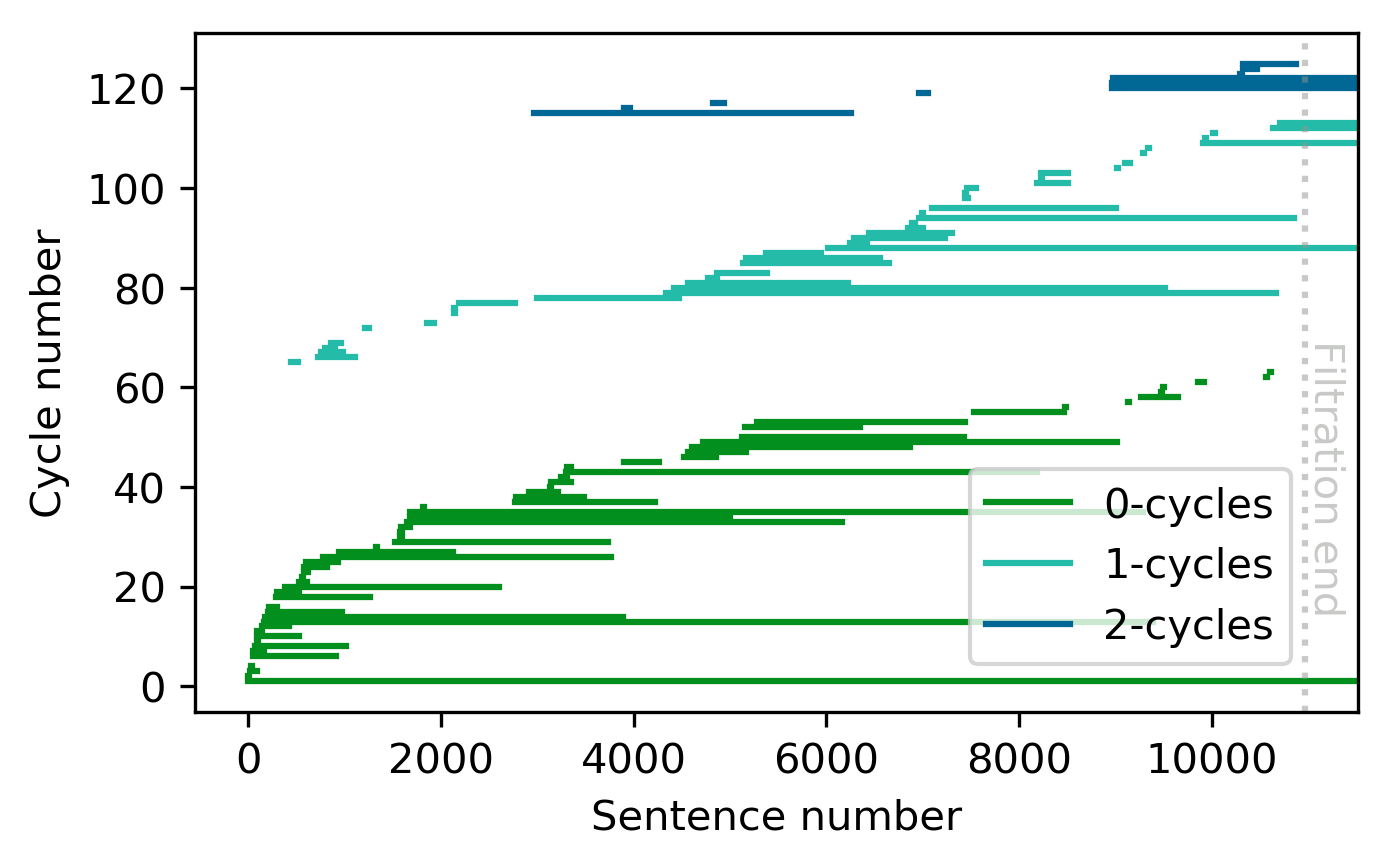

In [57]:
plt.figure(figsize=(5, 3), dpi=300)
plot_barcode(sent_bars[9], text_lens[9])
plt.savefig('figures/strang_barcode.pdf', transparent=True, bbox_inches='tight')

In [3]:
load_index_labels()[9]

array(['matrices', 'elimination', 'gauss', 'gaussian elimination',
       'linear algebra', 'linear equation', 'equation', 'linear',
       'algebra', 'determinant', 'subtract', 'second equation',
       'substitution', 'scientific computing', 'compute', 'left side',
       'cramer rule', 'algorithm', 'matrix', 'simplify', 'geometry',
       'dimension', 'dimensional', 'dimensional space', 'intersect',
       'vector', 'upper triangular', 'triangular', 'multiply',
       'triangular matrix', 'factorization', 'multiplication',
       'transpose', 'inverse', 'exceptional', 'singular', 'singular case',
       'infinitely', 'elimination step', 'subtraction', 'computer',
       'roundoff', 'roundoff error', 'row exchange', 'coefficient',
       'coefficient matrix', 'intersection', 'row picture',
       'column picture', 'linear system', 'vector equation',
       'column vector', 'time column', 'parallelogram', 'geometrically',
       'algebraically', 'three plane', 'three equation',
      

Let's plot the average $\pm$ 2 standard deviations of the Betti curves, as well as the Strang Betti curves as a representative.

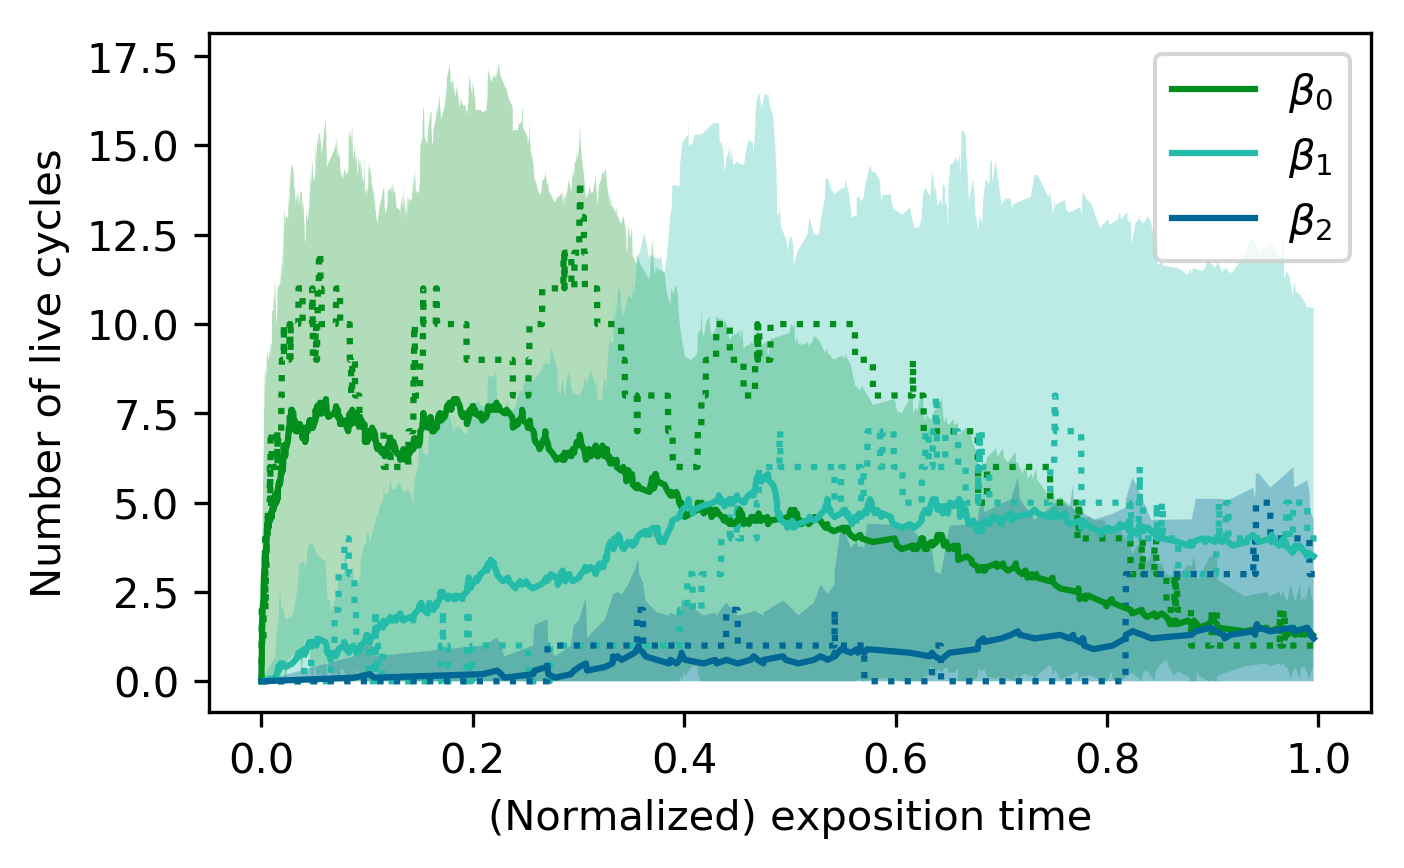

In [316]:
plt.figure(figsize=(5, 3), dpi=300)

strang_bettis = betti_curves(sent_bars[9], text_lens[9])
plt.plot(np.linspace(0, 1, strang_bettis.shape[1]), strang_bettis[0], 
         color='xkcd:emerald green', linestyle=':')
plt.plot(np.linspace(0, 1, strang_bettis.shape[1]), strang_bettis[1], 
         color='xkcd:tealish', linestyle=':')
plt.plot(np.linspace(0, 1, strang_bettis.shape[1]), strang_bettis[2], 
         color='xkcd:peacock blue', linestyle=':')
plot_bettis([betti_curves(sent_bars[i], text_lens[i])
                for i in range(10)])
plt.savefig('figures/alltexts_bettis.pdf', transparent=True, bbox_inches='tight')

Now we briefly explore some representative cycles - that is, the edges nodes/actually comprising these persistent cycles

In [4]:
from cyclonysus import Cycler

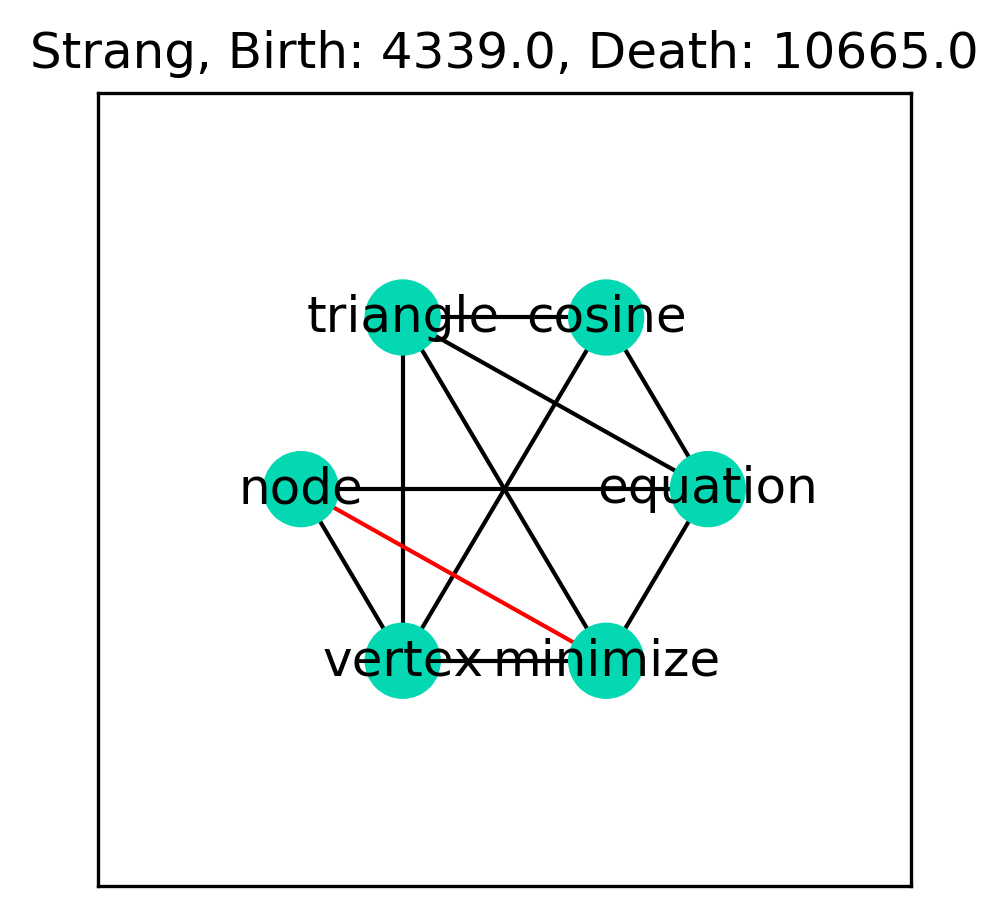

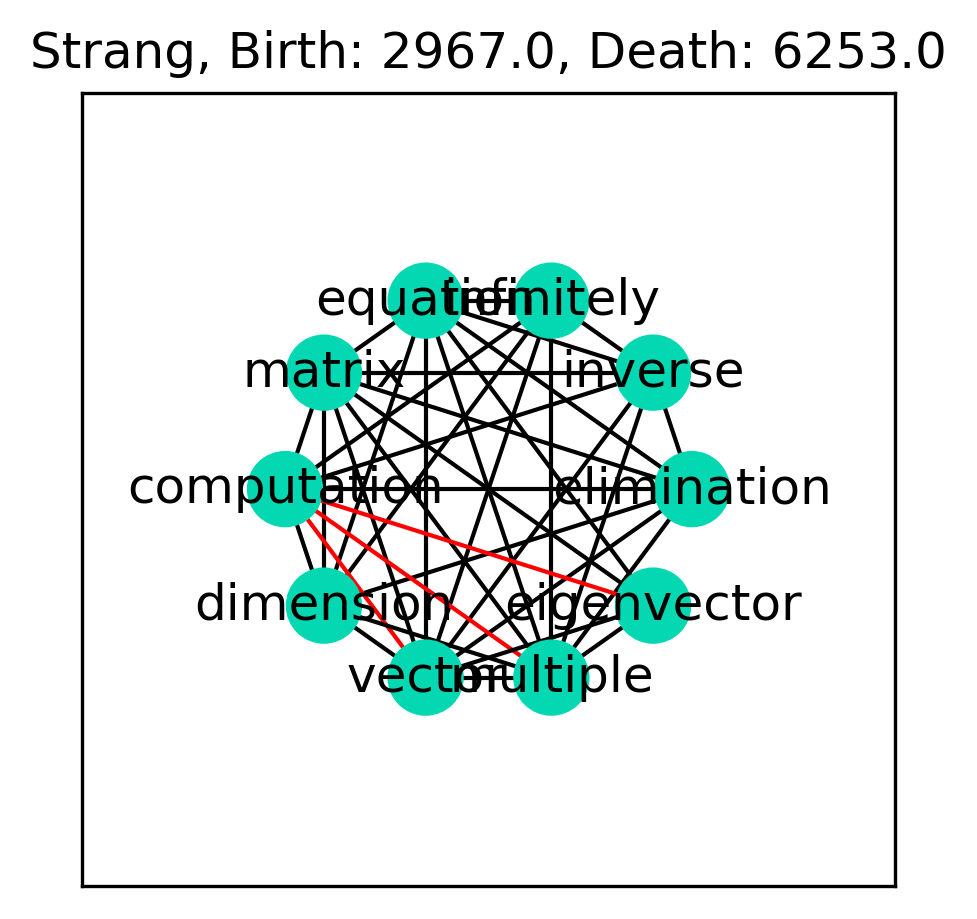

In [22]:
for j in range(9, 10):
    for i in range(1, 3):
        plt.figure(figsize=(3.5, 3.5), dpi=300)
        #print(texts[j])
        new_filt = sent_filts[j].copy()
        np.fill_diagonal(new_filt, 0)
        sq_dist = squareform(new_filt)
        sq_dist[sq_dist == np.inf] = text_lens[j]+1
        f = d.fill_rips(sq_dist, 3, text_lens[j])

        cycler = Cycler(order=i)
        cycler.from_simplices(simplices=f)
        # top 3 intervals
        top_intervals = cycler.longest_intervals(1)
        try:
            cycles = [cycler.get_cycle(interval) for interval in top_intervals]
        #     print(cycles)
            vertex_sets = [list(set().union(*c)) for c in cycles]
        #     print(vertex_sets)
            diagram = top_intervals[0]

            impt_verts = np.array(list(set(vertex_sets[0])))
        #         print(sent_filts[j][impt_verts, :][:, impt_verts])
            additional = list(zip(*np.where(sent_filts[j] == diagram.death)))
            additional = [a for a in additional if a[0] in impt_verts or a[1] in impt_verts]
            new_nodes = set().union(*additional)
            new_nodes = new_nodes.difference(impt_verts)
            impt_verts = list(impt_verts) + list(new_nodes)
            name_dict = dict(enumerate(labels[j][impt_verts]))
        #         print(name_dict)
            sub = sent_filts[j][impt_verts, :][:, impt_verts]
            np.fill_diagonal(sub, 0)
            #killing edge(s):
            death_edge = list(zip(*np.where(sub == diagram.death)))
            death_edge_set = set([tuple(sorted(x)) for x in death_edge])
            sub[sub >= diagram.death] = 0
            G = nx.from_numpy_array(sub)
            G.add_edges_from(death_edge_set)
            node_colors = ['xkcd:aquamarine' for _ in range(len(impt_verts))]
            #node_colors += ['red' for _ in range(len(new_nodes))]
            edge_colors = ['red' if (e[0], e[1]) in death_edge else 'black'
                                                 for e in 
                                                 G.edges()]
    #         print(diagram, text_lens[j])
    #         print(death_edge)
    #         print(sub)
            pos = nx.circular_layout(G)
            nx.draw_networkx(G, pos=pos, edge_color=edge_colors, 
                             node_color=node_colors, with_labels=False)

            new_pos = {name_dict[k]: v for k, v in pos.items()}
            nx.relabel_nodes(G, 
                         dict(enumerate(labels[j][impt_verts])),
                         copy=False)
            nx.draw_networkx_labels(G, pos=new_pos, font_color='black')
            plt.xlim([-2, 2])
            plt.ylim([-2, 2])
            plt.title('{}, Birth: {}, Death: {}'.format(texts[j],
                                                diagram.birth,
                                                diagram.death))
        except:
            pass
        plt.savefig('figures/strang_{}cycle.pdf'.format(i), transparent=True, bbox_inches='tight')
        plt.show()

In [23]:
import dionysus as d
from scipy.spatial.distance import squareform
# set diagonal to zero
j = 9
new_filt = sent_filts[j].copy()
np.fill_diagonal(new_filt, 0)
sq_dist = squareform(new_filt)
sq_dist[sq_dist == np.inf] = text_lens[j]+1
f = d.fill_rips(sq_dist, 3, text_lens[j])



In [24]:
cycler = Cycler(order=2)
cycler.from_simplices(simplices=f)

In [25]:
cycler.longest_intervals(1)


[(2967,6253)]

Here, we plot some of the particularly long-living cycles from each text (a 1-cycle and a 2-cycle for each)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


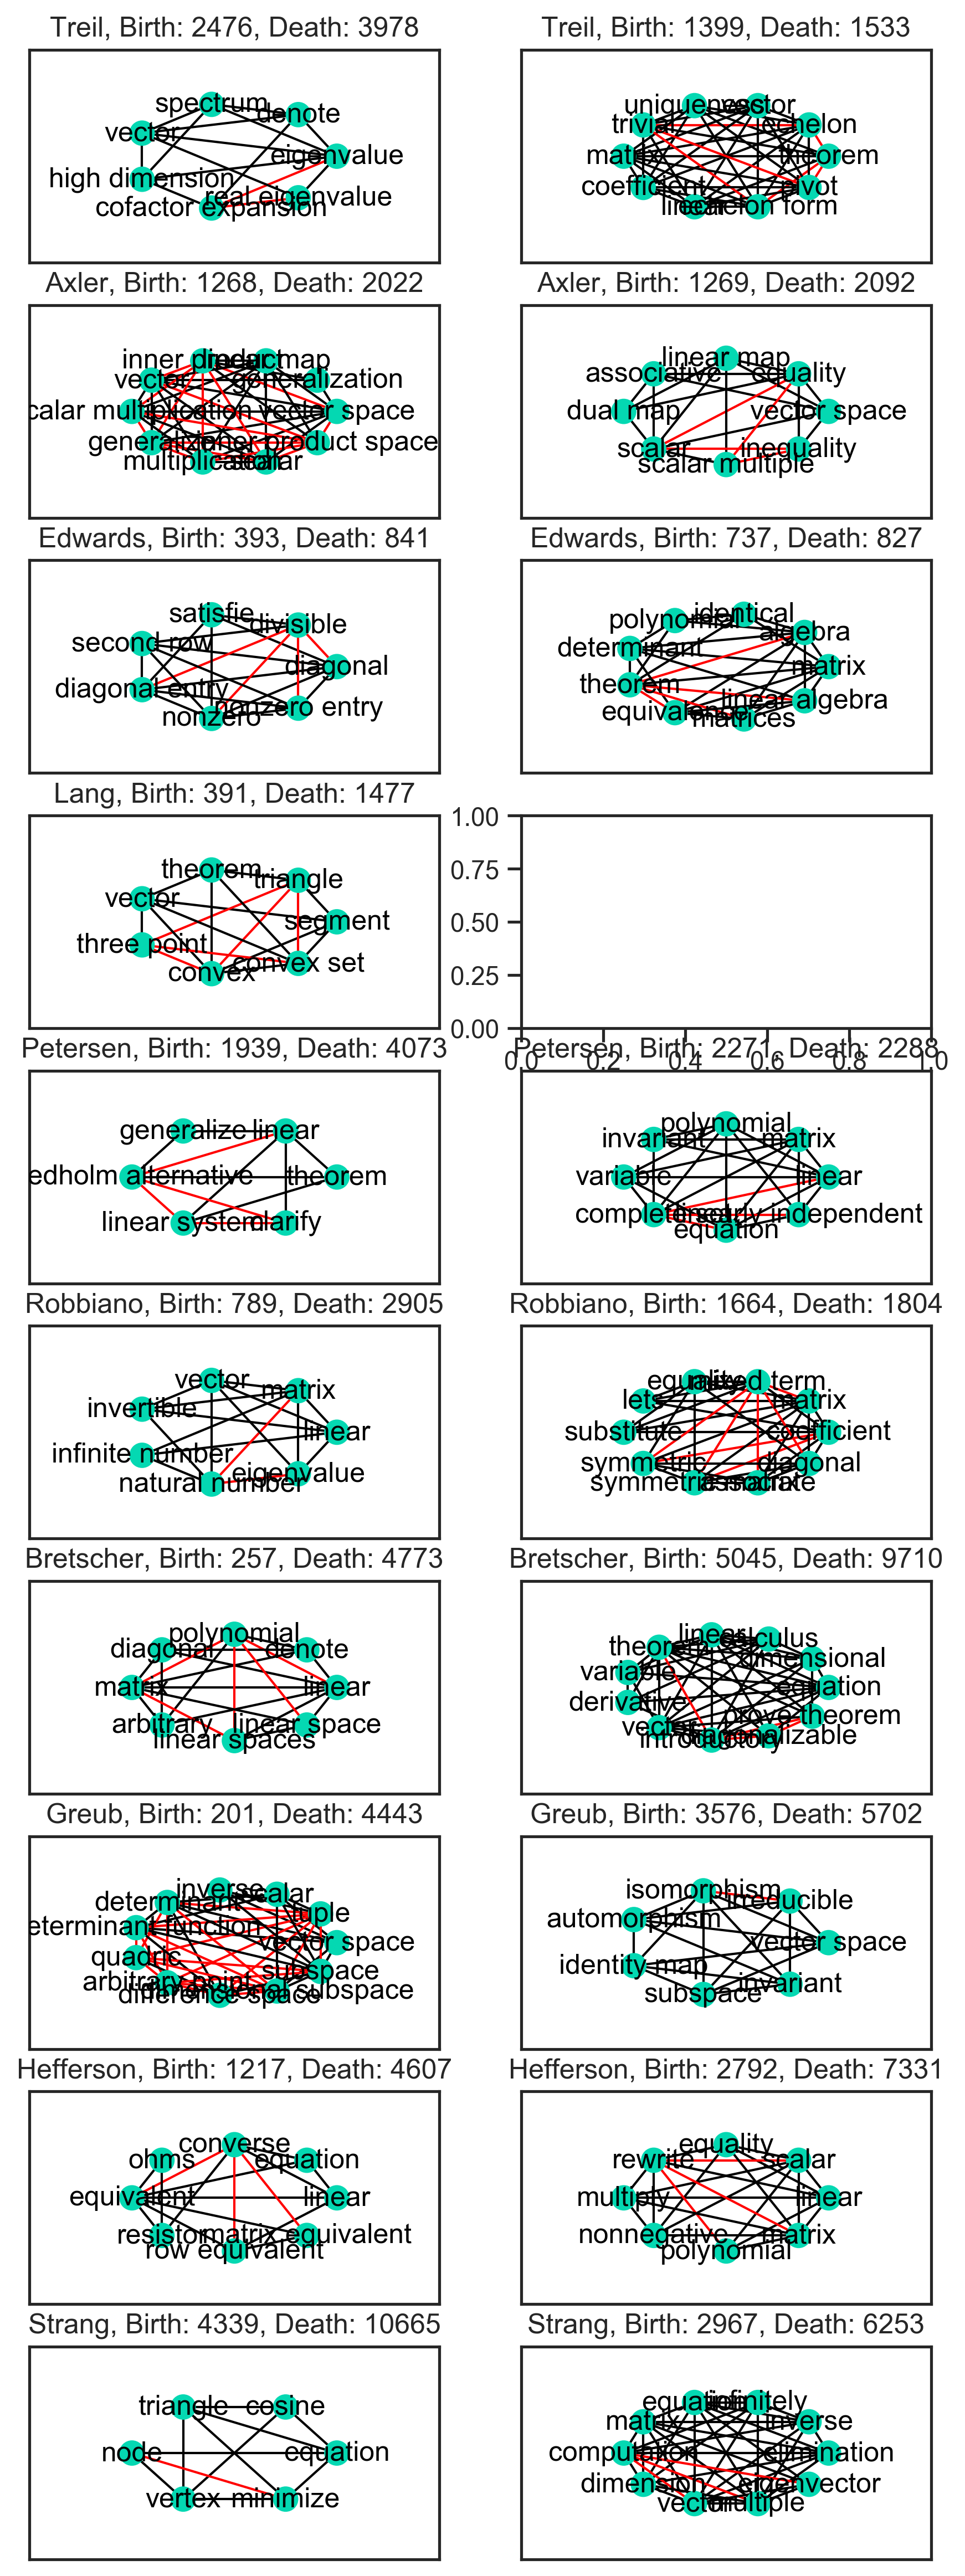

In [260]:
import dionysus as d
from scipy.spatial.distance import squareform
from cyclonysus import Cycler
labels = load_index_labels()
plt.figure(figsize=(7, 20), dpi=300)
for j in range(10):
    for i in range(1, 3):
        #print(texts[j])
        plt.subplot(10, 2, 2*j+i)
        new_filt = sent_filts[j].copy()
        np.fill_diagonal(new_filt, 0)
        sq_dist = squareform(new_filt)
        sq_dist[sq_dist == np.inf] = text_lens[j]+1
        f = d.fill_rips(sq_dist, 3, text_lens[j])

        cycler = Cycler(order=i)
        cycler.from_simplices(simplices=f)
        # top 3 intervals
        top_intervals = cycler.longest_intervals(1)
        try:
            cycles = [cycler.get_cycle(interval) for interval in top_intervals]
        #     print(cycles)
            vertex_sets = [list(set().union(*c)) for c in cycles]
        #     print(vertex_sets)
            diagram = top_intervals[0]

            impt_verts = np.array(list(set(vertex_sets[0])))
        #         print(sent_filts[j][impt_verts, :][:, impt_verts])
            additional = list(zip(*np.where(sent_filts[j] == diagram.death)))
            additional = [a for a in additional if a[0] in impt_verts or a[1] in impt_verts]
            new_nodes = set().union(*additional)
            new_nodes = new_nodes.difference(impt_verts)
            impt_verts = list(impt_verts) + list(new_nodes)
            name_dict = dict(enumerate(labels[j][impt_verts]))
        #         print(name_dict)
            sub = sent_filts[j][impt_verts, :][:, impt_verts]
            np.fill_diagonal(sub, 0)
            #killing edge(s):
            death_edge = list(zip(*np.where(sub == diagram.death)))
            death_edge_set = set([tuple(sorted(x)) for x in death_edge])
            sub[sub >= diagram.death] = 0
            G = nx.from_numpy_array(sub)
            G.add_edges_from(death_edge_set)
            node_colors = ['xkcd:aquamarine' for _ in range(len(impt_verts))]
            #node_colors += ['red' for _ in range(len(new_nodes))]
            edge_colors = ['red' if (e[0], e[1]) in death_edge else 'black'
                                                 for e in 
                                                 G.edges()]
    #         print(diagram, text_lens[j])
    #         print(death_edge)
    #         print(sub)
            pos = nx.circular_layout(G)
            nx.draw_networkx(G, pos=pos, edge_color=edge_colors, 
                             node_color=node_colors, with_labels=False, node_size=100)

            new_pos = {name_dict[k]: v for k, v in pos.items()}
            nx.relabel_nodes(G, 
                         dict(enumerate(labels[j][impt_verts])),
                         copy=False)
            nx.draw_networkx_labels(G, pos=new_pos, font_color='black')
            plt.xlim([-2, 2])
            plt.ylim([-2, 2])
            plt.title('{}, Birth: {}, Death: {}'.format(plottexts[j],
                                                int(diagram.birth),
                                                int(diagram.death)))
        except:
            pass
plt.savefig('figures/lots_of_cycles.pdf', transparent=True, bbox_inches='tight')
plt.show()

(Note these representative cycles didn't make their way into the final paper)

# RESULTS PART 4

Now, we shall compare persistent homology across each of the null models.
Start by loading all the oaat and null models data:

In [3]:
r_ind_sent_bars = load_r_ind_sent_bars()
r_sentord_sent_bars = load_r_sentord_sent_bars()


oaat_bars = load_oaat_bars()
r_ind_oaat_bars = load_r_ind_oaat_bars()
r_sentord_oaat_bars = load_r_sentord_oaat_bars()
rand_edge_bars = load_rand_edge_bars()
node_ord_bars = load_node_ord_bars()
#topo_dist_bars = load_topo_dist_bars()

In [4]:
all_bars = [sent_bars, r_ind_sent_bars, r_sentord_sent_bars]

all_oaat_bars = [oaat_bars, r_ind_oaat_bars, r_sentord_oaat_bars, rand_edge_bars, 
            node_ord_bars]# , topo_dist_bars]

We plot all the barcodes and bettis (actual text & nulls) for Treil

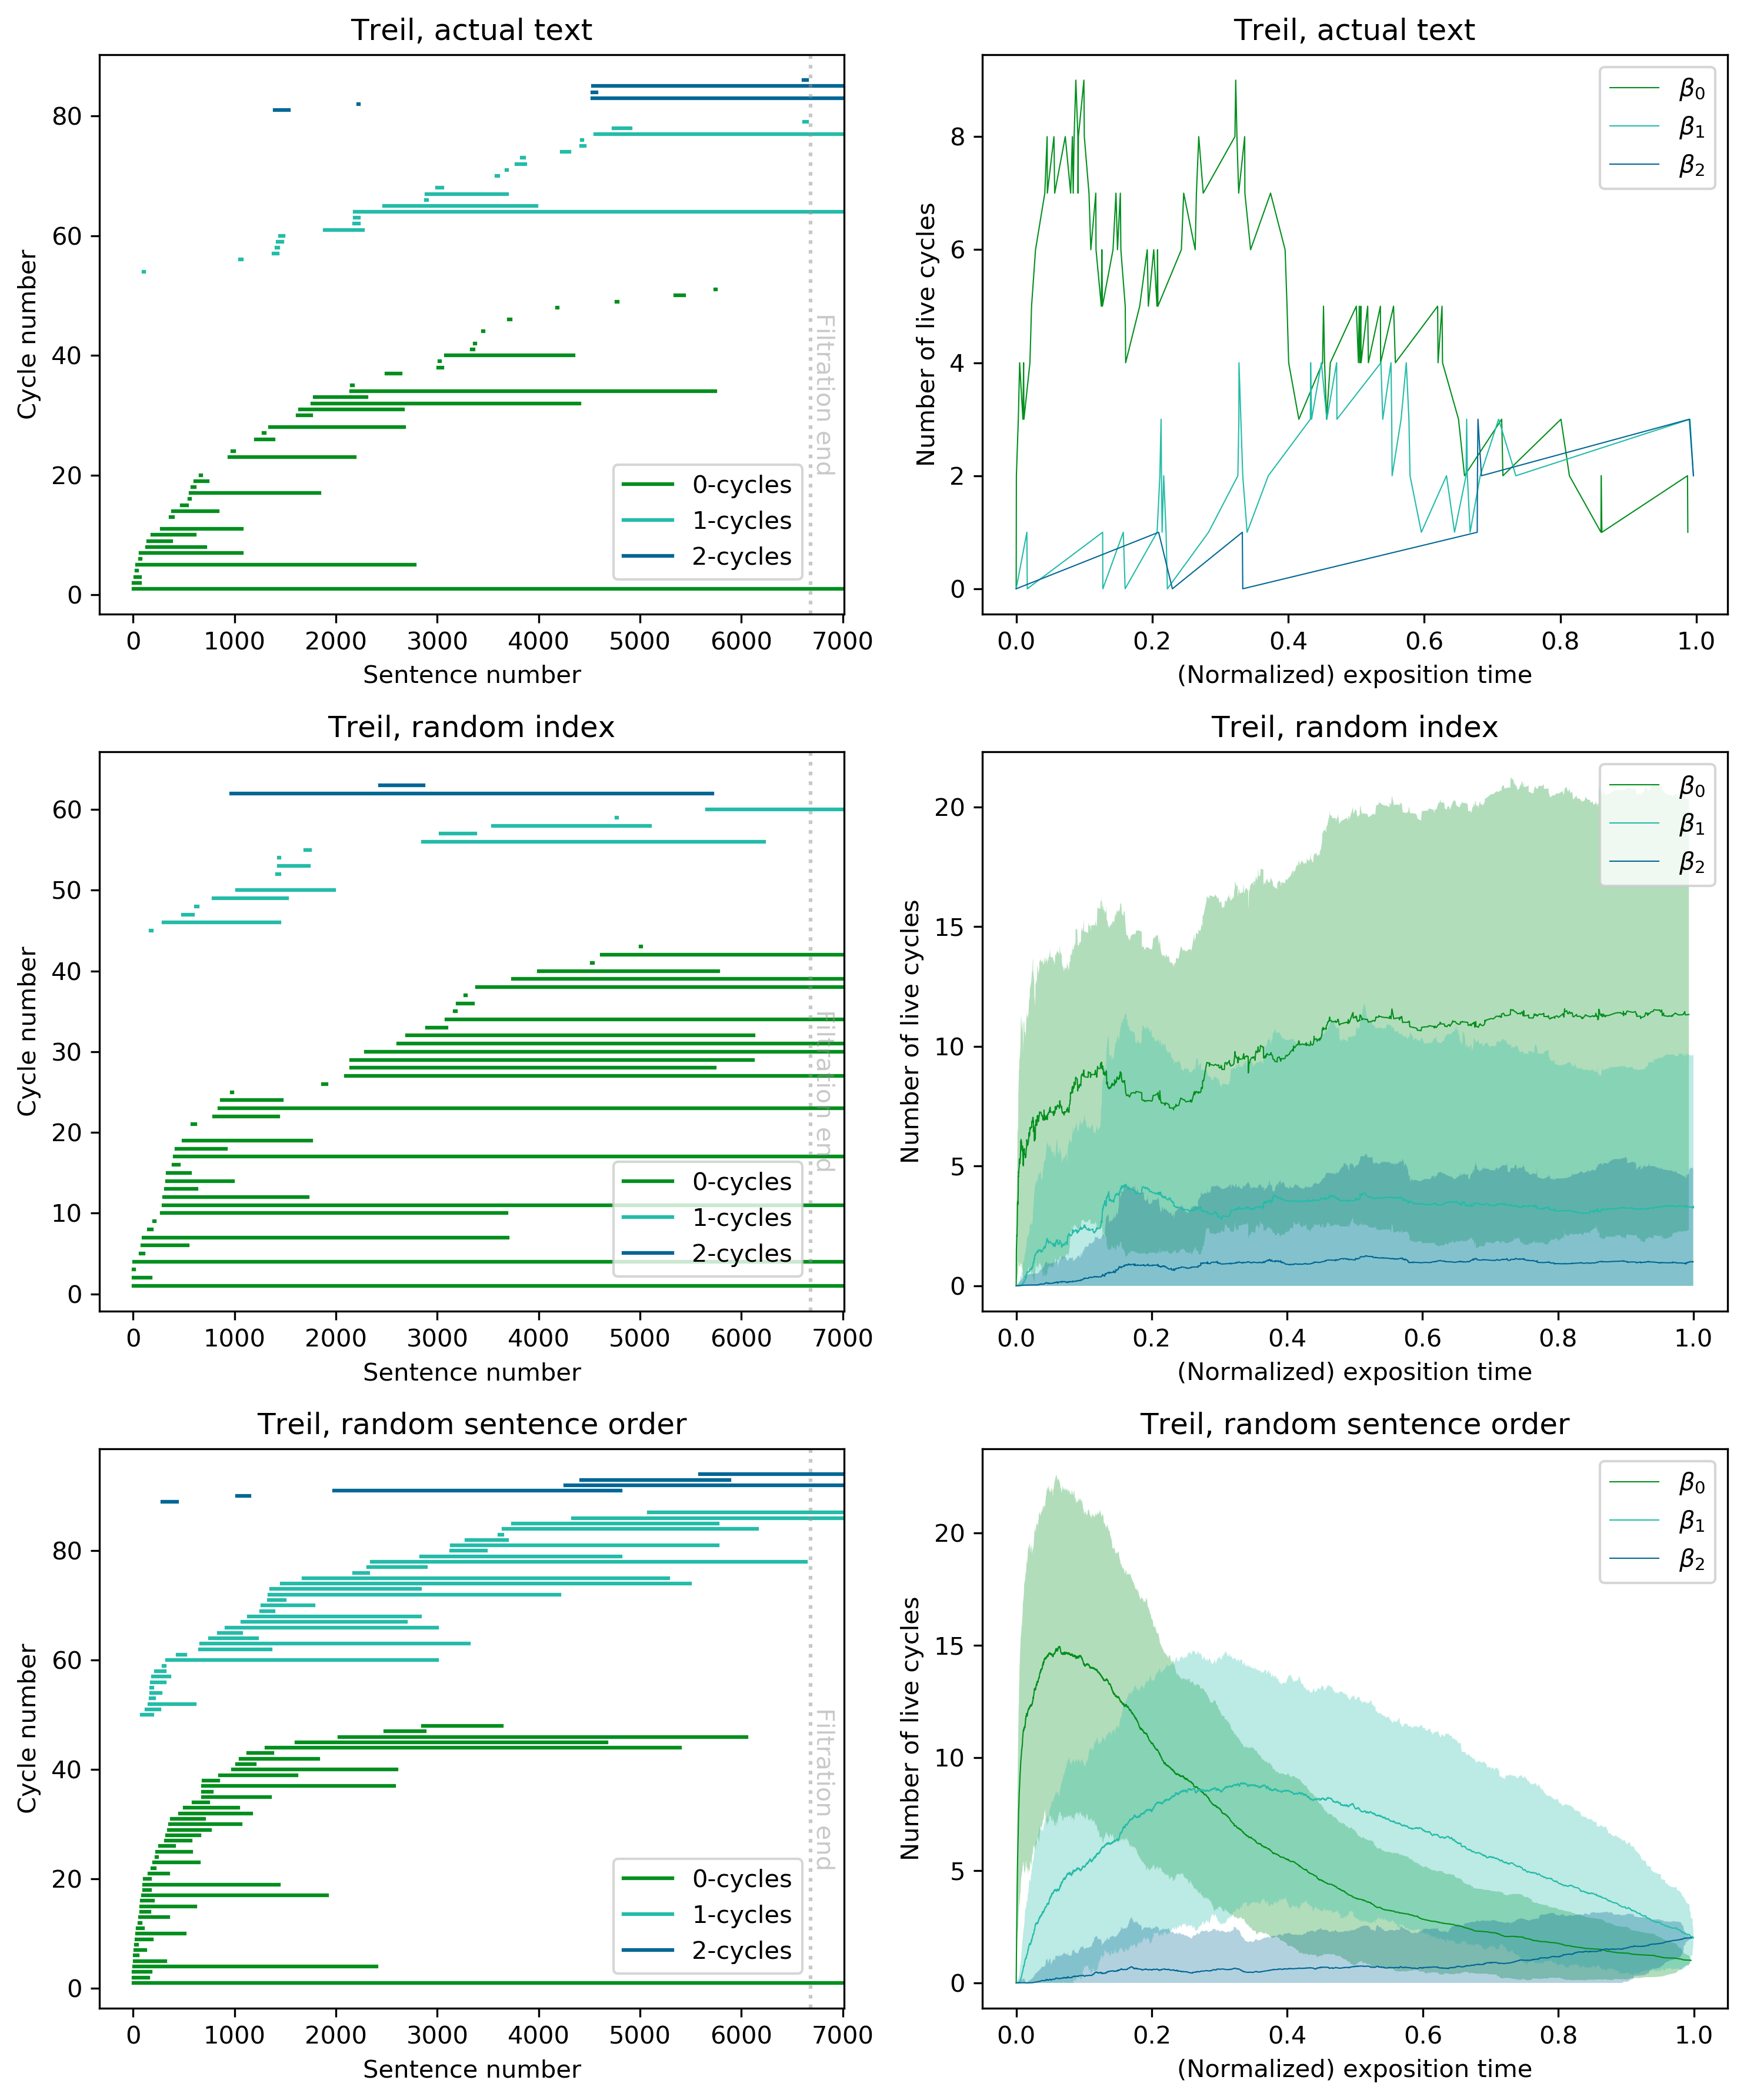

In [6]:
plt.figure(figsize=(10, 12), dpi=300)
i = 0

plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
modelnames = ['actual text', 'random index', 'random sentence order']#, 'topological distance']

for j in tqdm_notebook(range(len(all_bars))):
    now_bar = all_bars[j]
    plt.subplot(3, 2, 2*j+1)
    plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
    if modelnames[j] == 'actual text':
        plot_barcode(list(map(tuple, now_bar[i])), text_lens[i])
    else:
        plot_barcode(list(map(tuple, now_bar[i][0])), text_lens[i])
    plt.subplot(3, 2, 2*j+2)
    plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
    if modelnames[j] == 'actual text':
        all_bettis = [betti_curves(list(map(tuple, now_bar[i])), text_lens[i])]
    else:
        all_bettis = [betti_curves(list(map(tuple, now_bar[i][k])), text_lens[i])
                  for k in range(100)]
    plot_bettis(all_bettis)
plt.tight_layout()
plt.savefig('figures/ph_nulls_treil_sent.pdf', transparent=True, bbox_inches='tight')

plt.show()

And then for every single one of the texts, using the sentence and the oaat filtrations:

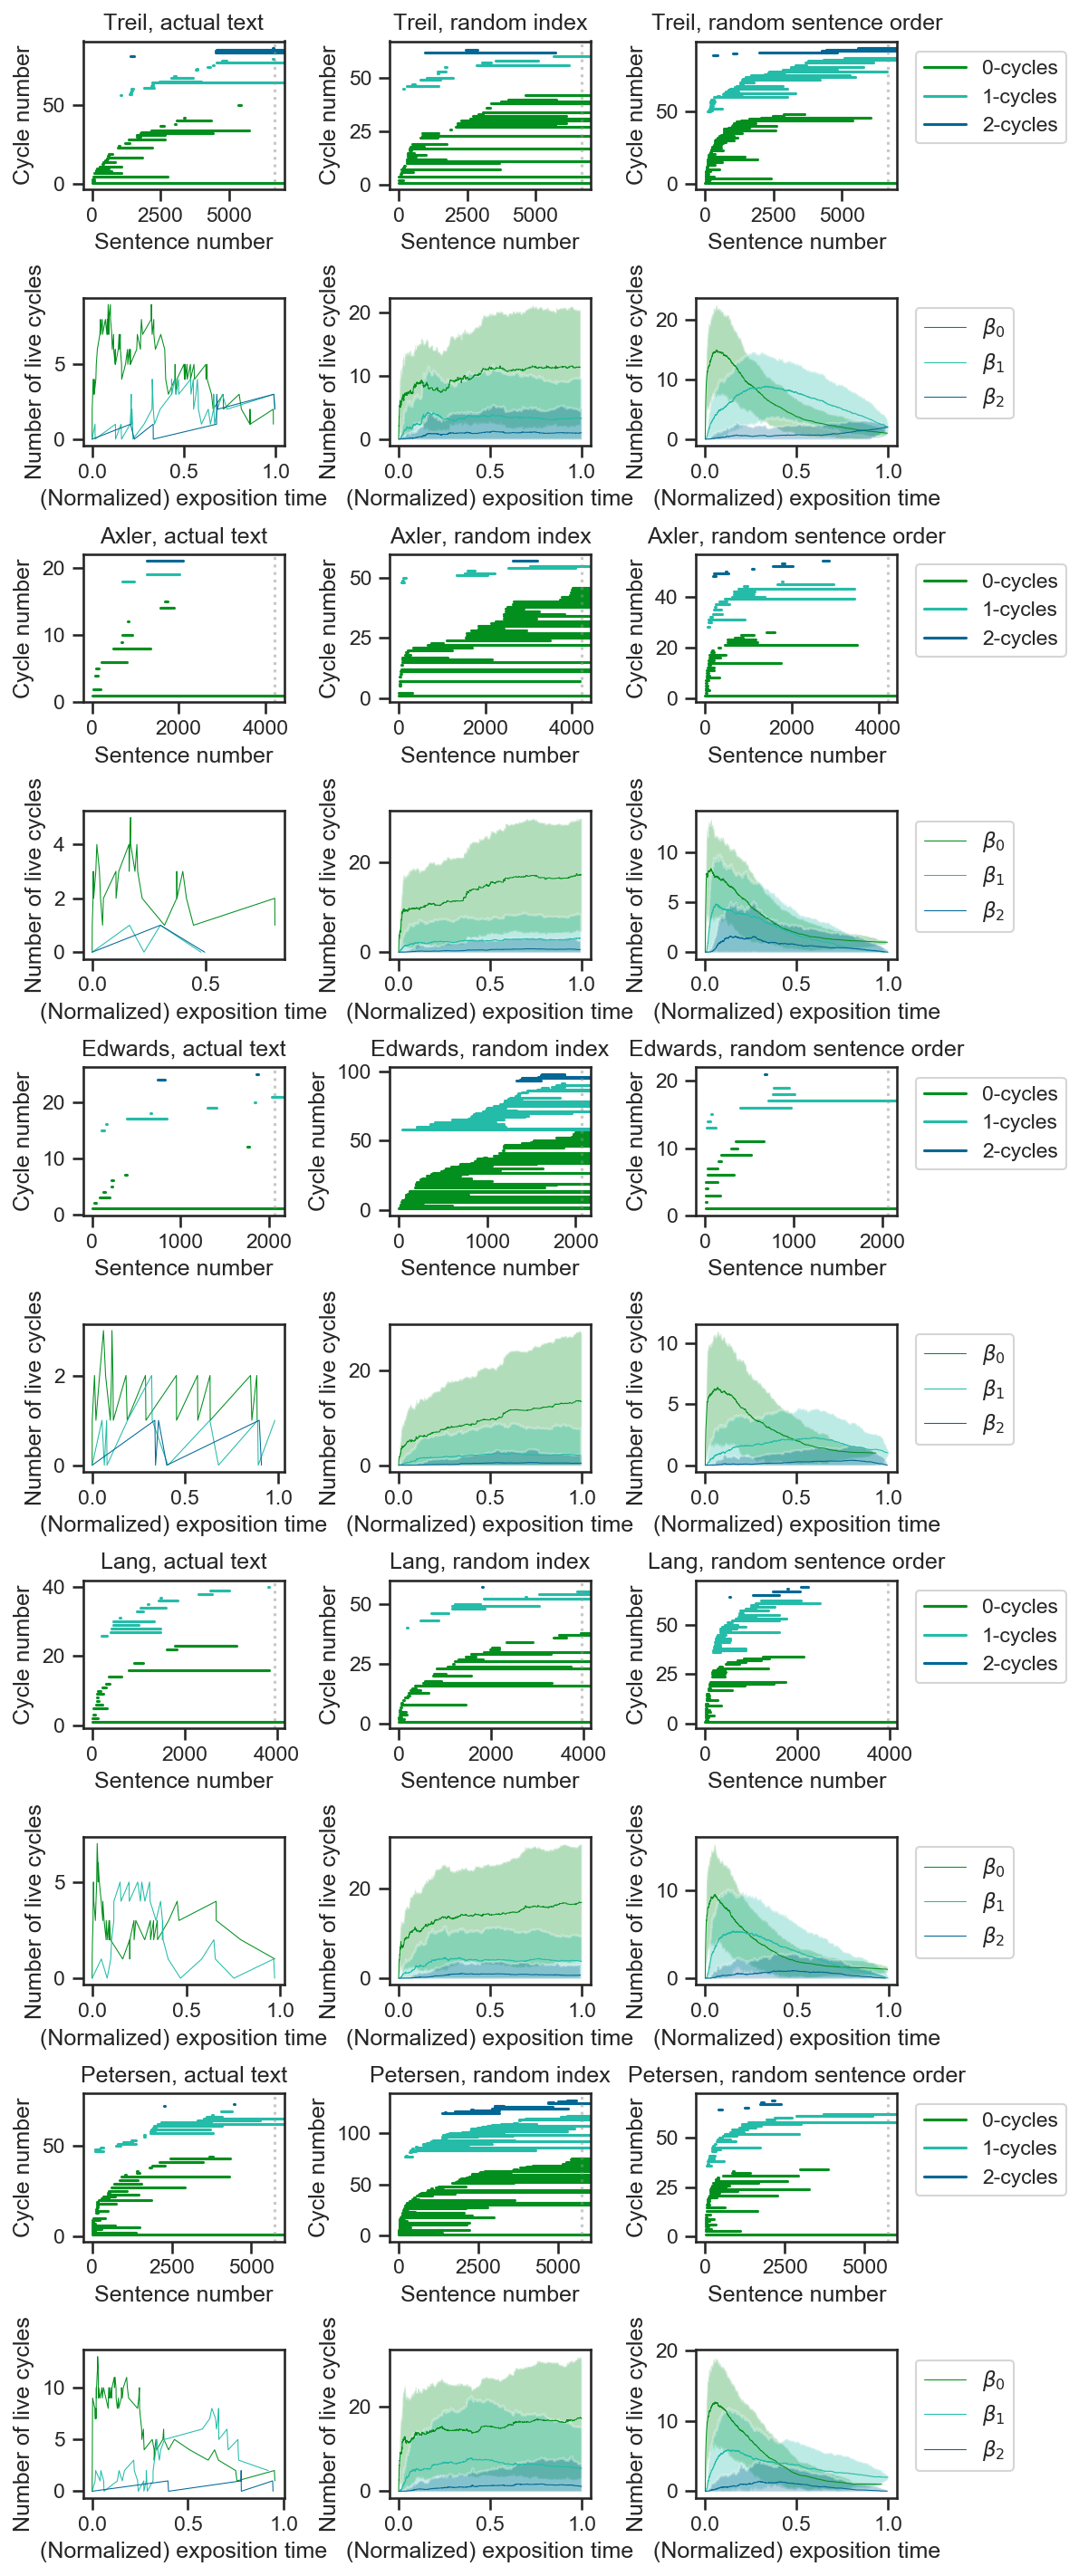

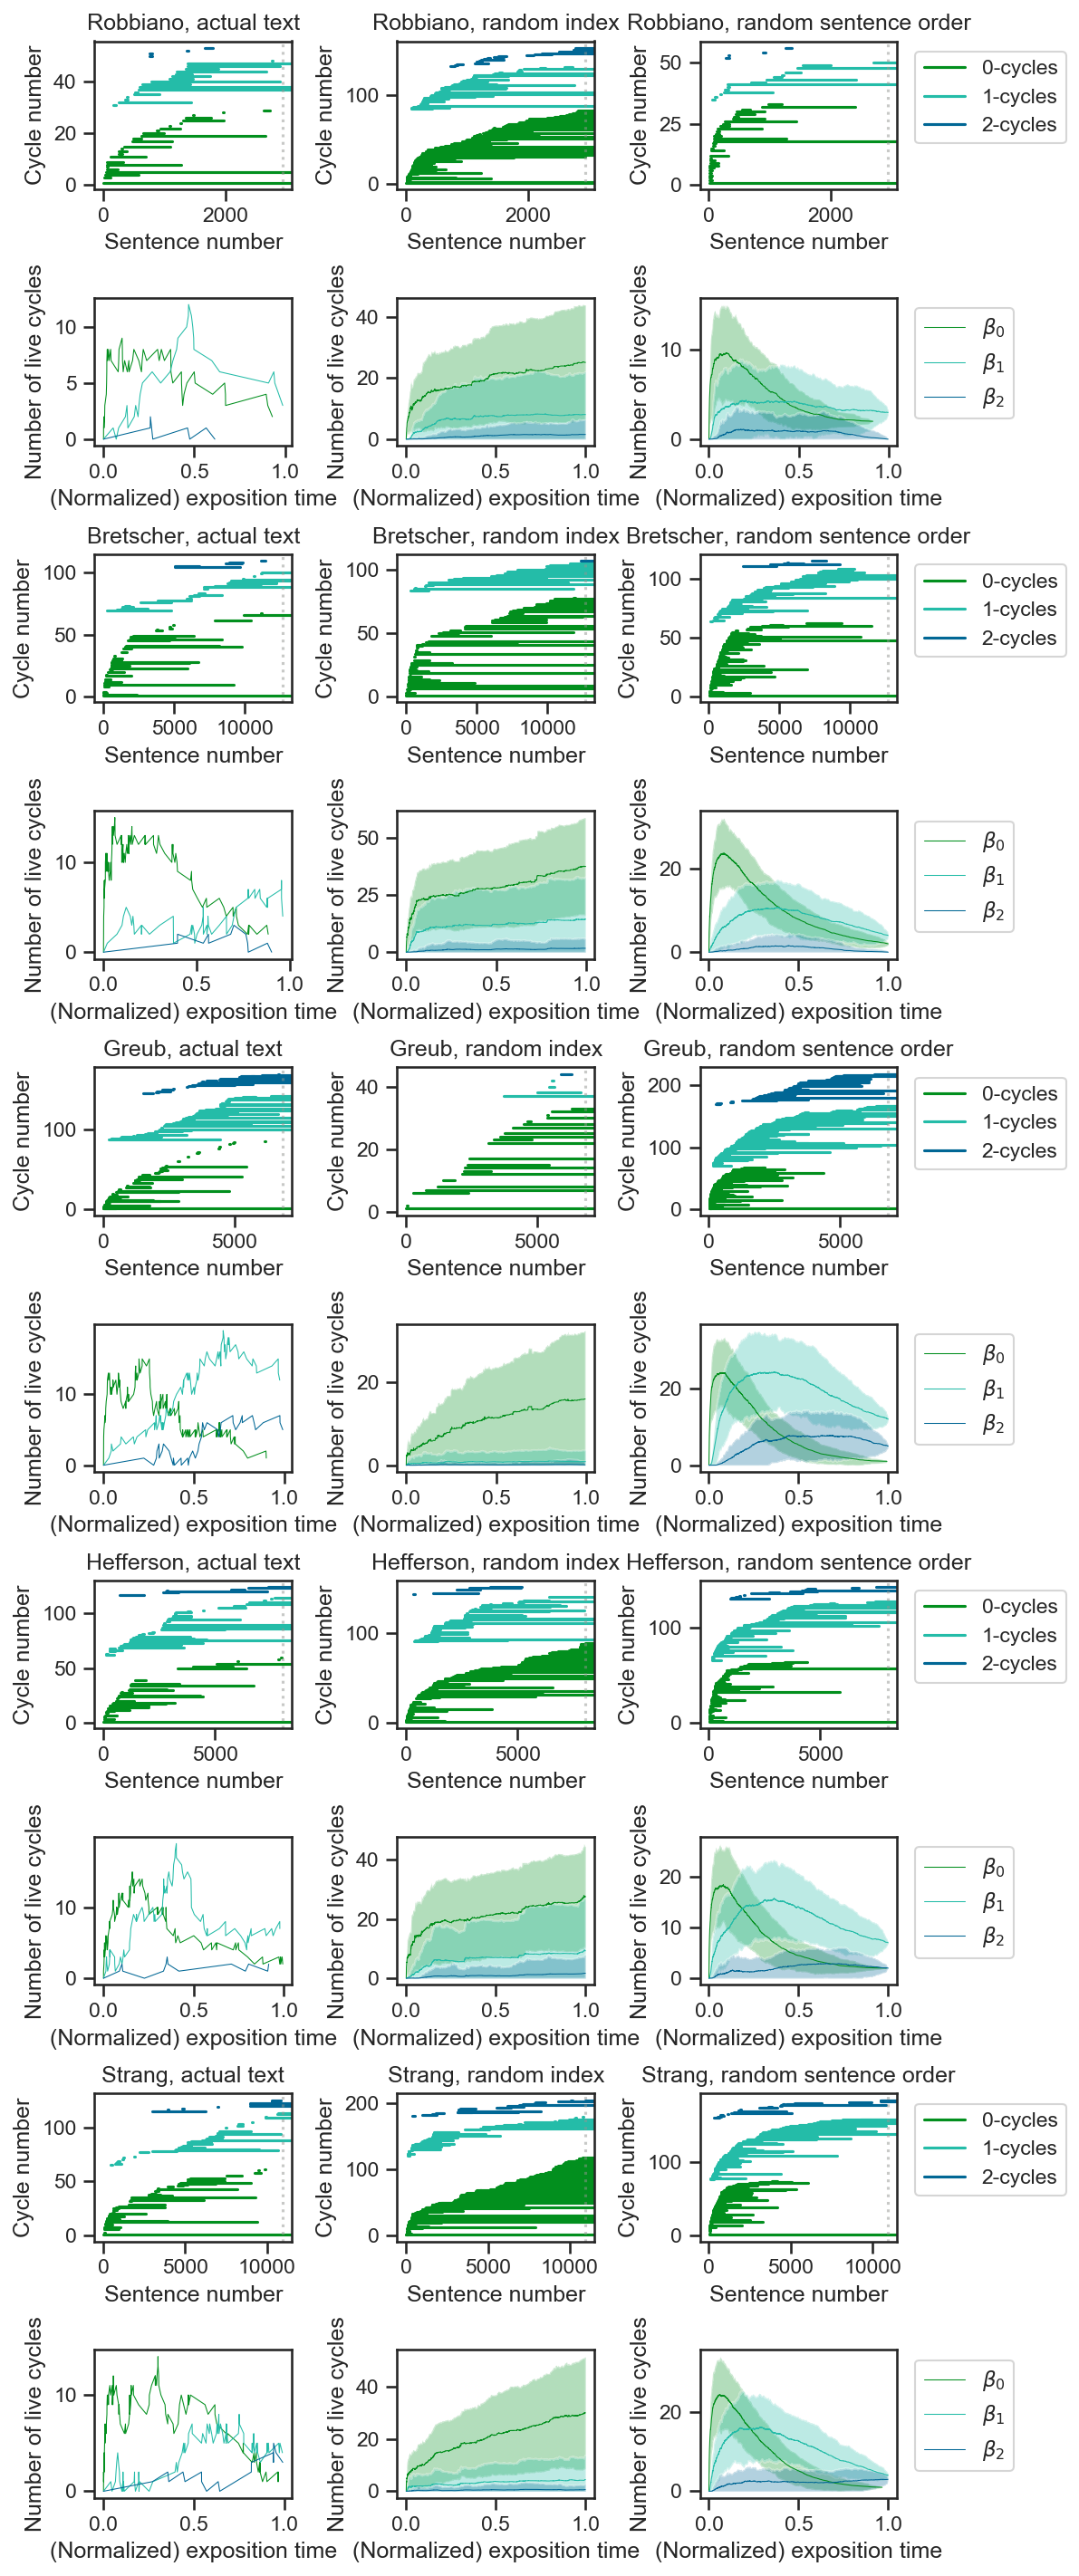

In [8]:
modelnames = ['actual text', 'random index', 'random sentence order']
plt.figure(figsize=(8, 19), dpi=150)
from matplotlib import font_manager 
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
modelnames = ['actual text', 'random index', 'random sentence order']
for i in tqdm_notebook(range(5)):
    for j in range(len(all_bars)):
        now_bar = all_bars[j]
        plt.subplot(10, 3, 6*i+j+1)
        plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
        if modelnames[j] == 'actual text':
            plot_barcode(list(map(tuple, now_bar[i])), text_lens[i], end=False)
        else:
            plot_barcode(list(map(tuple, now_bar[i][0])), text_lens[i], end=False)
        if j == 2:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.subplot(10, 3, 6*i+j+4)
        if modelnames[j] == 'actual text':
            all_bettis = [betti_curves(list(map(tuple, now_bar[i])), text_lens[i])]
        else:
            all_bettis = [betti_curves(list(map(tuple, now_bar[i][k])), text_lens[i])
                      for k in range(100)]
        plot_bettis(all_bettis)
        if j == 2:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('figures/ph_sent_nulls_all_1.png', transparent=True, bbox_inches='tight')
plt.show()
plt.figure(figsize=(8, 19), dpi=150)
for i in tqdm_notebook(range(5, 10)):
    for j in range(len(all_bars)):
        now_bar = all_bars[j]
        plt.subplot(10, 3, 6*(i-5)+j+1)
        plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
        if modelnames[j] == 'actual text':
            plot_barcode(list(map(tuple, now_bar[i])), text_lens[i], end=False)
        else:
            plot_barcode(list(map(tuple, now_bar[i][0])), text_lens[i], end=False)
        if j == 2:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.subplot(10, 3, 6*(i-5)+j+4)
        if modelnames[j] == 'actual text':
            all_bettis = [betti_curves(list(map(tuple, now_bar[i])), text_lens[i])]
        else:
            all_bettis = [betti_curves(list(map(tuple, now_bar[i][k])), text_lens[i])
                      for k in range(100)]
        plot_bettis(all_bettis)
        if j == 2:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

    
plt.tight_layout()
plt.savefig('figures/ph_sent_nulls_all_2.png', transparent=True, bbox_inches='tight')
plt.show()

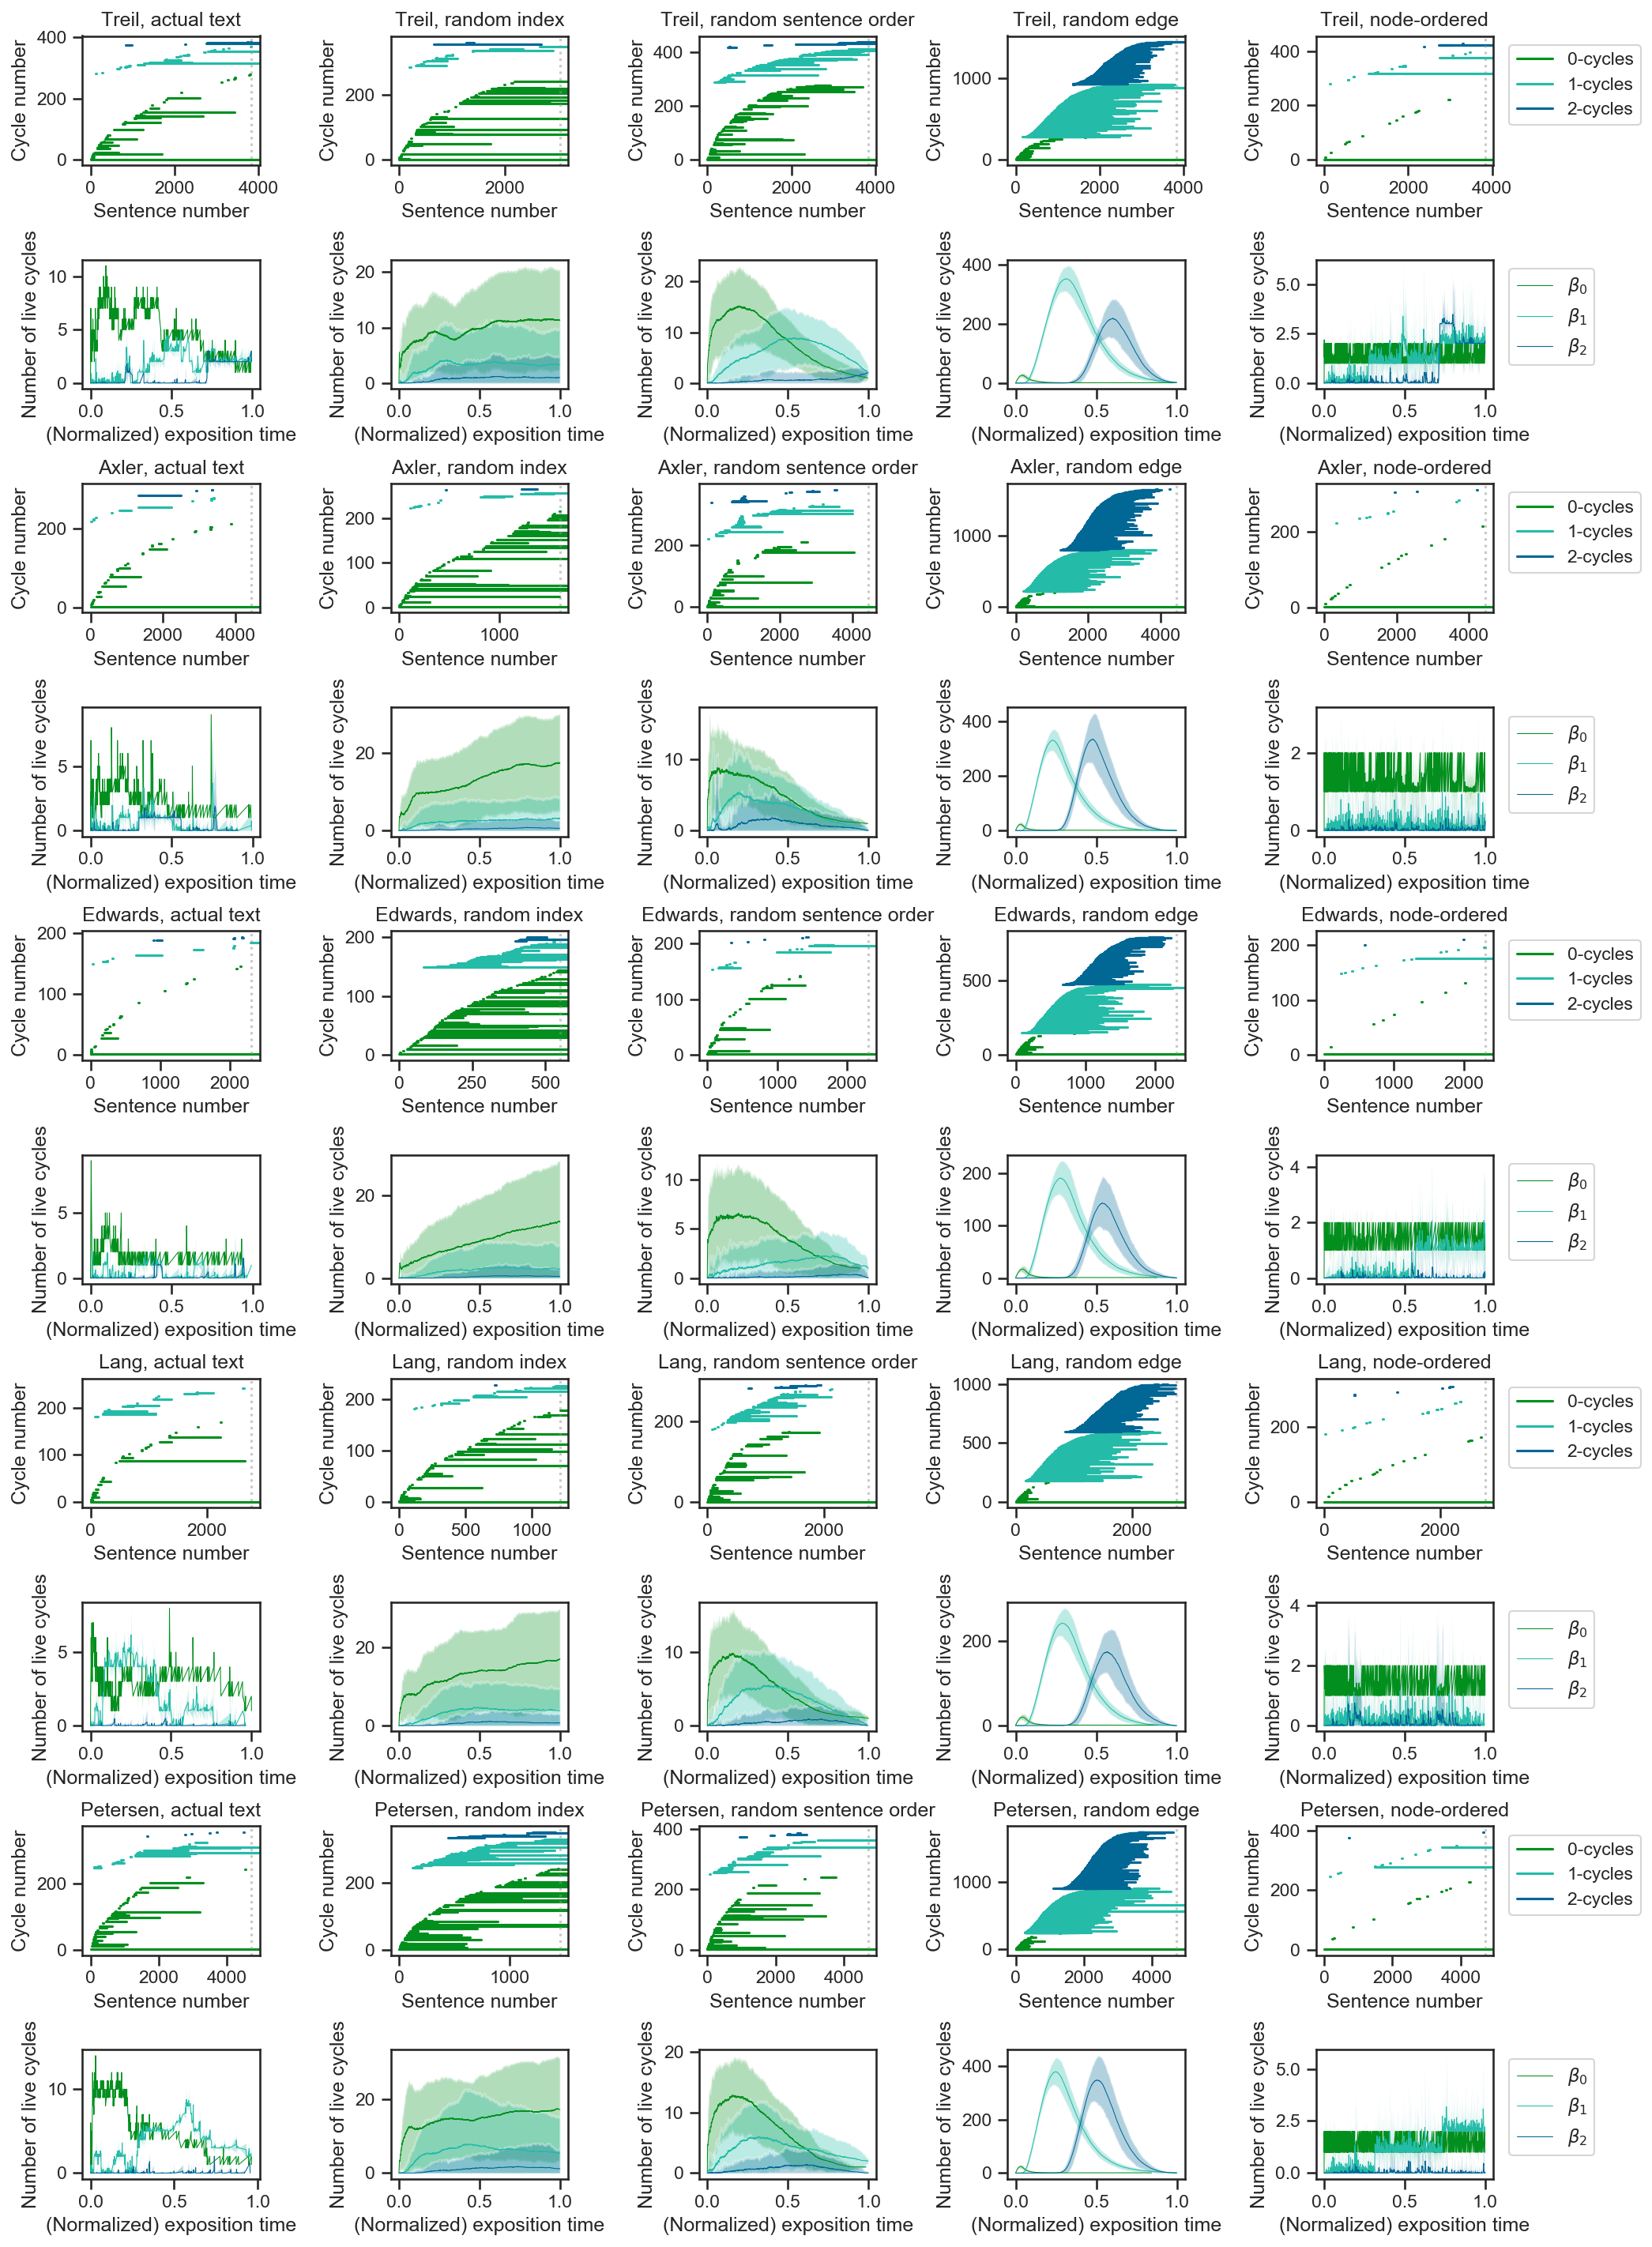

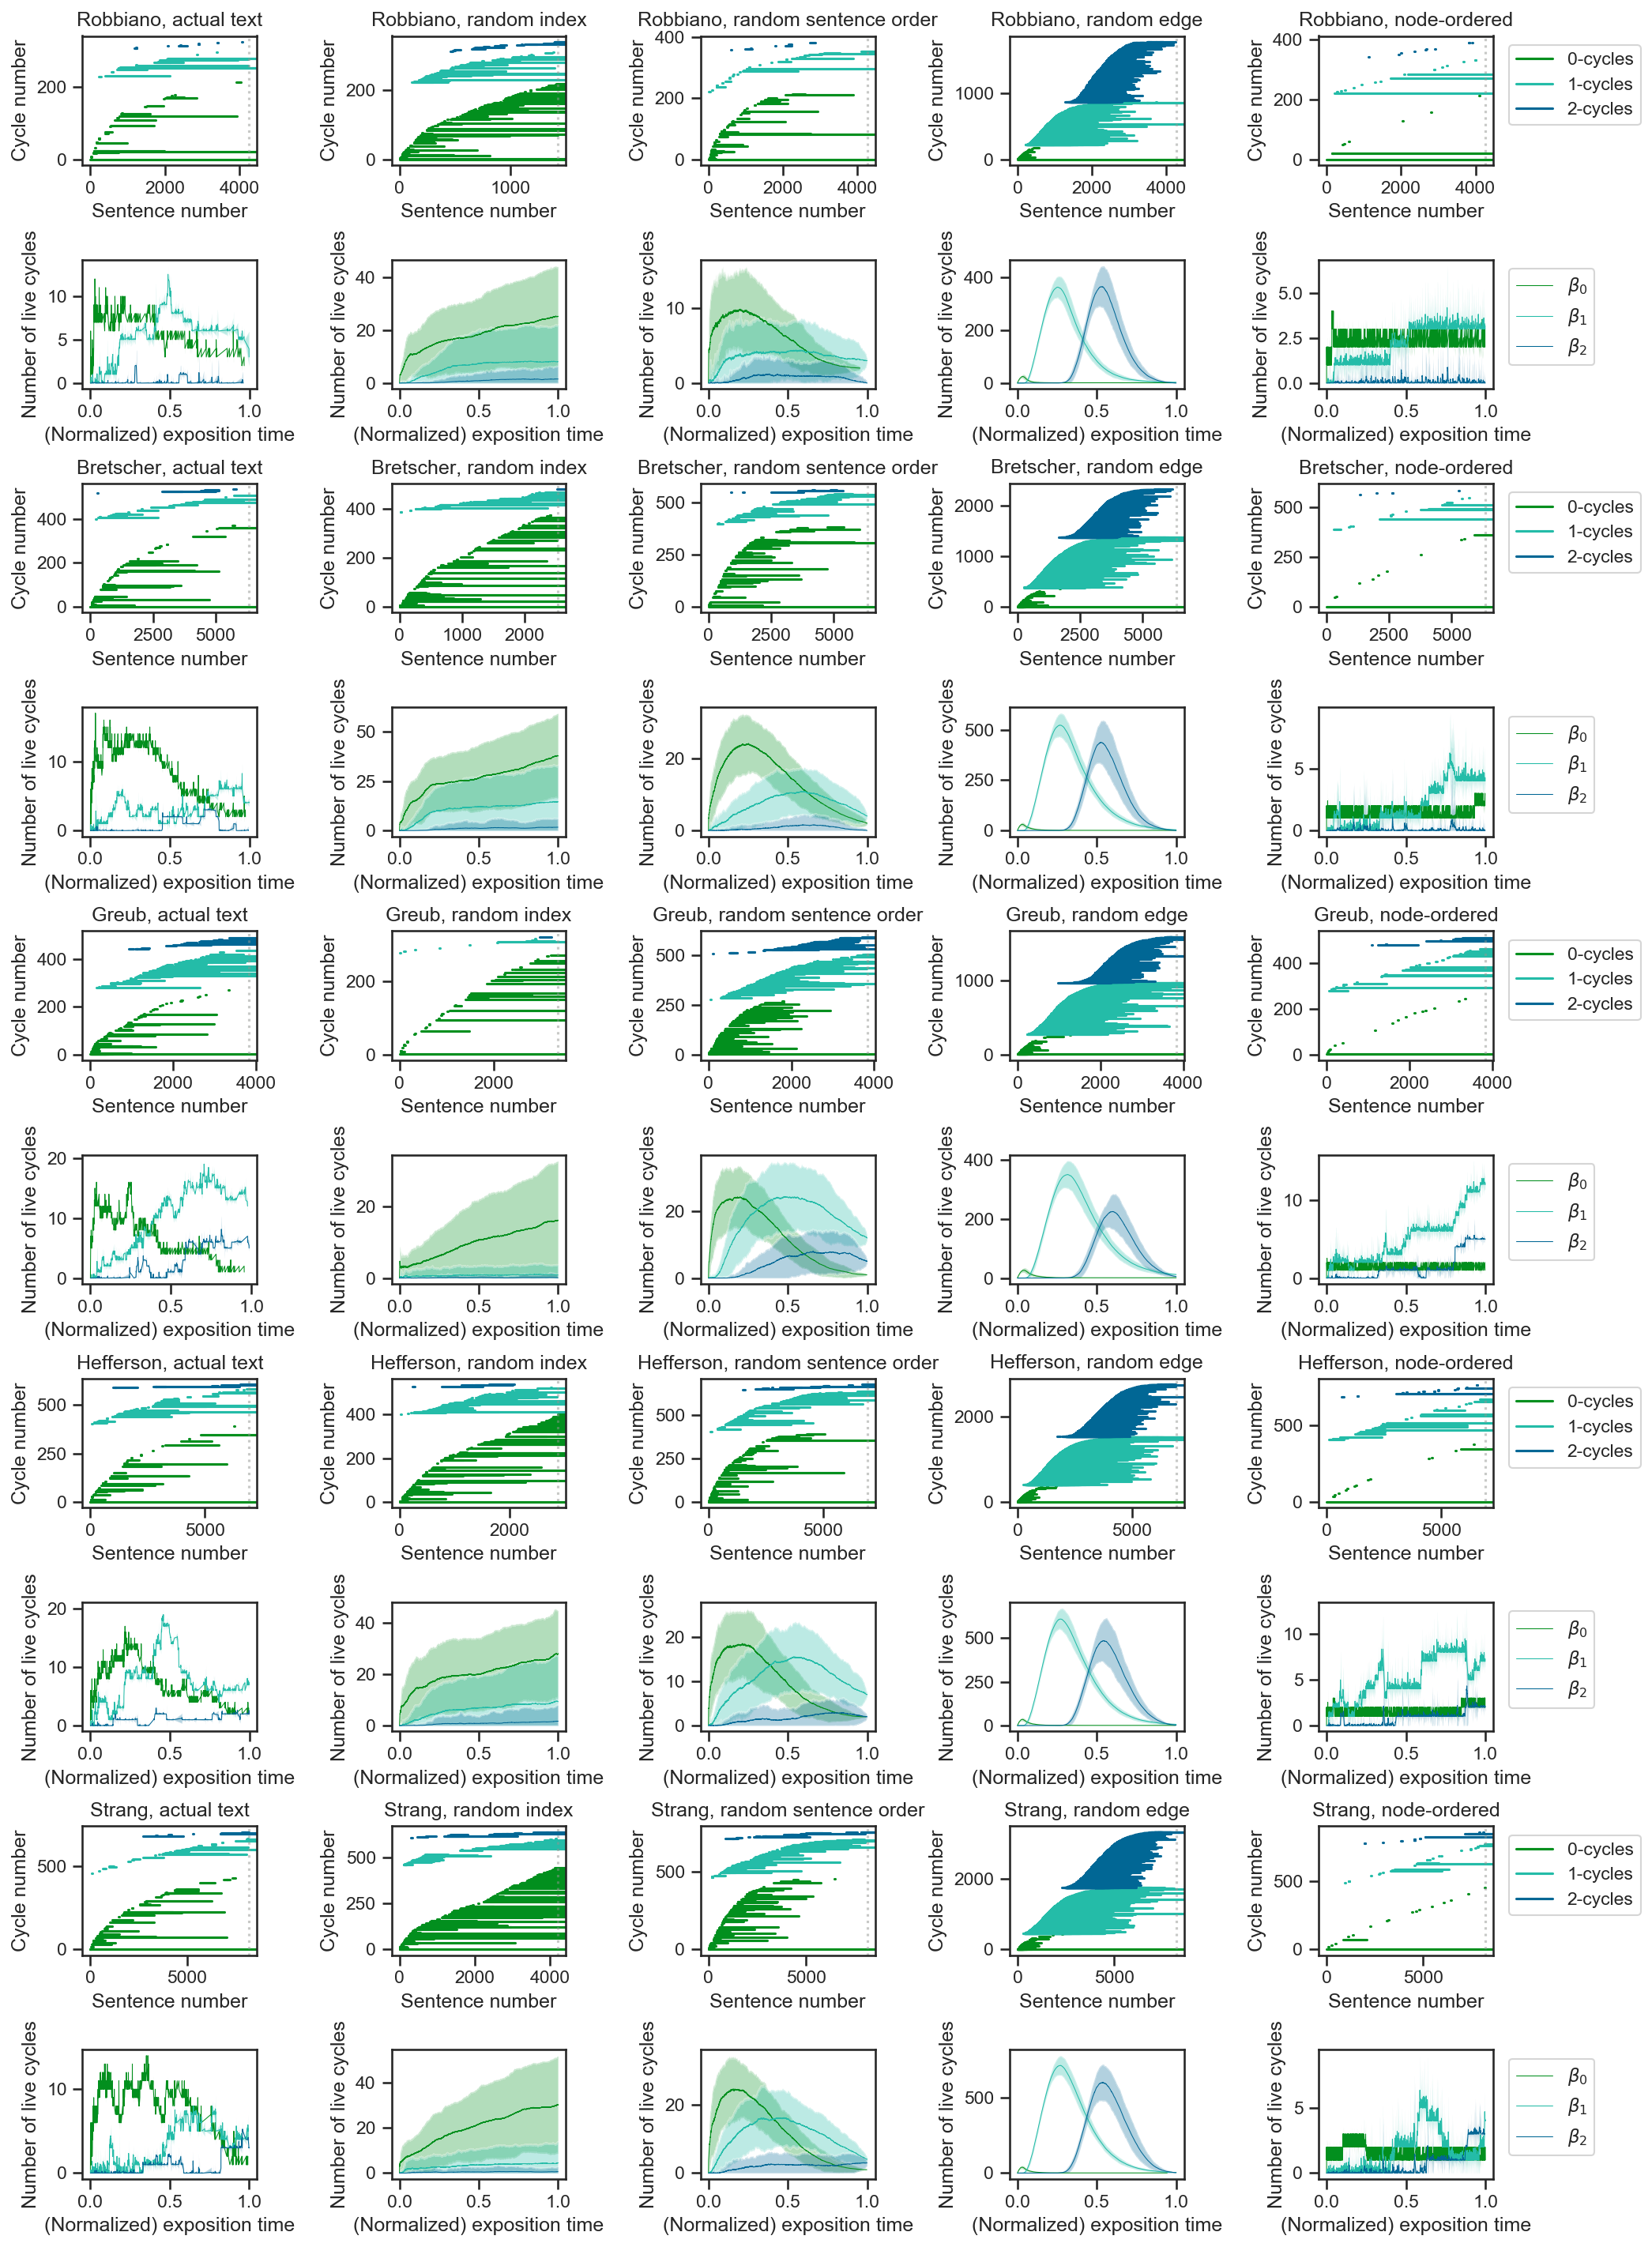

In [9]:
modelnames = ['actual text', 'random index', 'random sentence order', 'random edge', 'node-ordered']
matplotlib.rcParams.update({'font.size': 8})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(14, 19), dpi=150)
for i in tqdm_notebook(range(5)):
    for j in range(len(all_oaat_bars)):
        now_bar = all_oaat_bars[j]
        plt.subplot(10, 5, 10*i+j+1)
        plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
        plot_barcode(now_bar[i][0][1], now_bar[i][0][0], end=False)
        if j == 4:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.subplot(10, 5, 10*i+j+6)
        all_bettis = [betti_curves(now_bar[i][j][1], now_bar[i][j][0])
                      for j in range(100)]
        plot_bettis(all_bettis)
        if j == 4:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('figures/ph_nulls_all_1.png', transparent=True, bbox_inches='tight')
plt.show()
plt.figure(figsize=(14, 19), dpi=150)
for i in tqdm_notebook(range(5,10)):
    for j in range(len(all_oaat_bars)):
        now_bar = all_oaat_bars[j]
        plt.subplot(10, 5, 10*(i-5)+j+1)
        plt.title('{}, {}'.format(plottexts[i], modelnames[j]))
        plot_barcode(now_bar[i][0][1], now_bar[i][0][0], end=False)
        if j == 4:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.subplot(10, 5, 10*(i-5)+j+6)
        all_bettis = [betti_curves(now_bar[i][j][1], now_bar[i][j][0])
                      for j in range(100)]
        plot_bettis(all_bettis)
        if j == 4:
            plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('figures/ph_nulls_all_2.png', transparent=True, bbox_inches='tight')
plt.show()

Now let's do some fun stuff with the barcode density (normalized average cycle lifetime).

First we compute all the densities and other associated information.

In [5]:
true_oaat_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(oaat_bars[i][j][1], 
                                     oaat_bars[i][j][0]))
    reses = np.stack(reses)
    true_oaat_density[i] = reses
    
true_sent_density = np.zeros((10, 4, 3))
for i in range(10):
    res = barcode_density(sent_bars[i], text_lens[i])
    true_sent_density[i] = res
    
r_ind_sent_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(r_ind_sent_bars[i][j], 
                                     text_lens[i]))
    reses = np.stack(reses)
    r_ind_sent_density[i] = reses
    
r_ind_oaat_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(r_ind_oaat_bars[i][j][1], 
                                     r_ind_oaat_bars[i][j][0]))
    reses = np.stack(reses)
    r_ind_oaat_density[i] = reses
    
r_sentord_sent_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(r_sentord_sent_bars[i][j], 
                                     text_lens[i]))
    reses = np.stack(reses)
    r_sentord_sent_density[i] = reses
    
r_sentord_oaat_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(r_sentord_oaat_bars[i][j][1], 
                                     r_sentord_oaat_bars[i][j][0]))
    reses = np.stack(reses)
    r_sentord_oaat_density[i] = reses
    
rand_edge_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(rand_edge_bars[i][j][1], 
                                     rand_edge_bars[i][j][0]))
    reses = np.stack(reses)
    rand_edge_density[i] = reses

node_ord_density = np.zeros((10, 100, 4, 3))
for i in range(10):
    reses = []
    for j in range(100):
        reses.append(barcode_density(node_ord_bars[i][j][1], 
                                     node_ord_bars[i][j][0]))
    reses = np.stack(reses)
    node_ord_density[i] = reses
    
# topo_dist_density = np.zeros((10, 100, 4, 3))
# for i in range(10):
#     reses = []
#     for j in range(100):
#         reses.append(barcode_density(topo_dist_bars[i][j][1], 
#                                      topo_dist_bars[i][j][0]))
#     reses = np.stack(reses)
#     topo_dist_density[i] = reses

/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:520: RuntimeWarning: invalid value encountered in true_divide
  normed_density = densities/nums


Now, we do a violinplot for the normalized average cycle lifetime on just the random index and sentence order nulls

In [6]:
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [r_ind_sent_density, r_sentord_sent_density]
model_names = ['Random index', 'Random sentence order']
big_df = []
for m in range(len(models)):
    for i in range(10):
        for d in range(3):
            df = pd.DataFrame({'Barcode Density': models[m][i, :, 2, d],
                               'Text': plottexts[i],
                               'Model': model_names[m],
                               'dimension': d})
            big_df.append(df)
big_df = pd.concat(big_df)

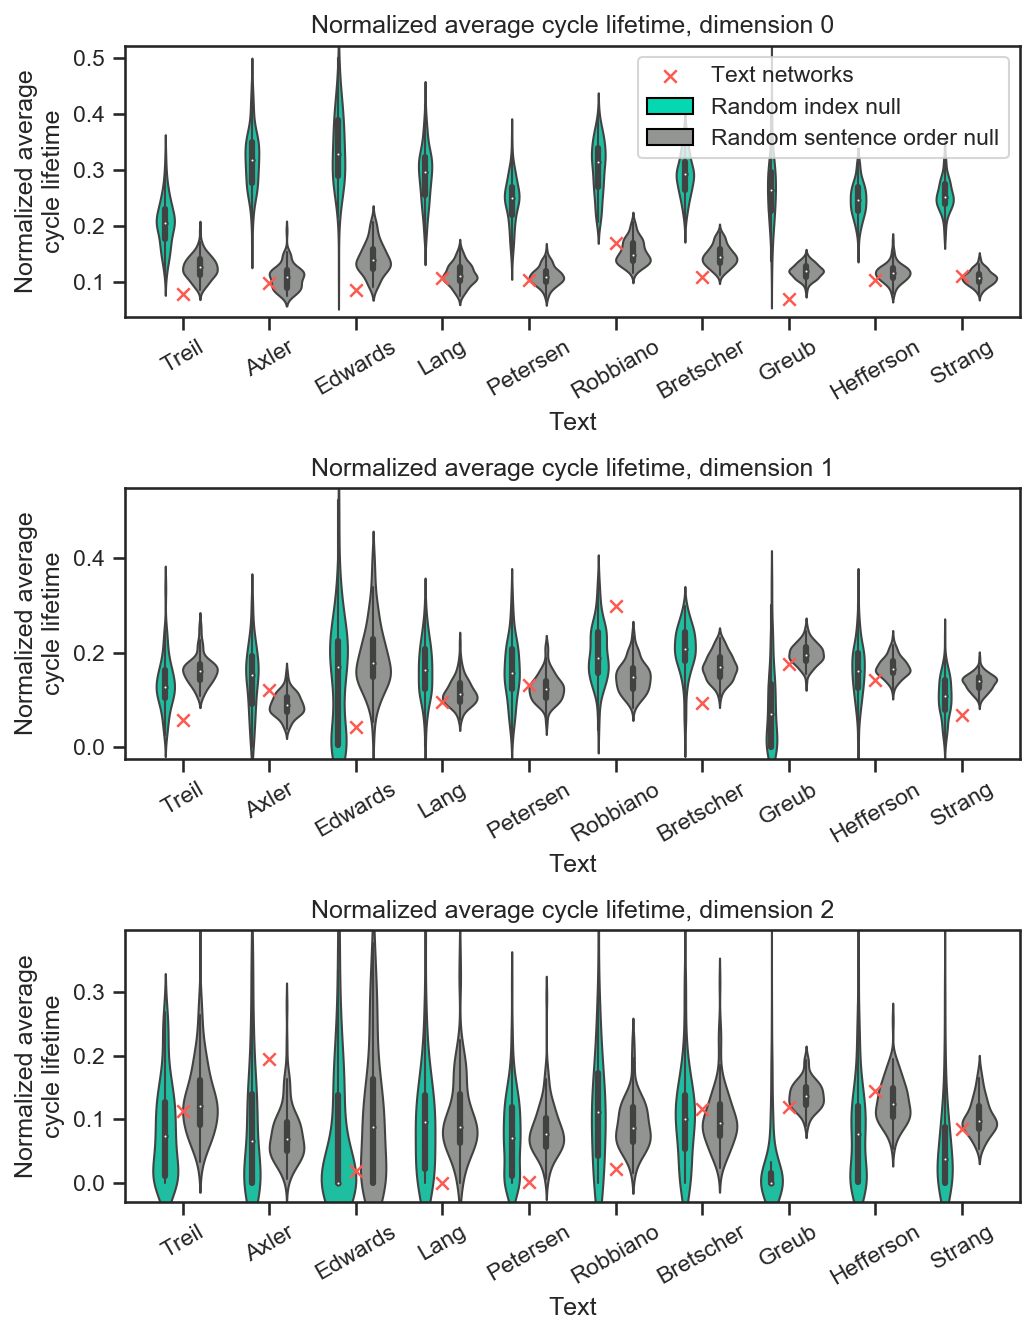

In [7]:
from matplotlib.patches import Patch
colors = ['xkcd:aquamarine', 'xkcd:grey']
plt.figure(figsize=(7, 9), dpi=150)
for d in range(3):
    plt.subplot(3,1, d+1)
    #plt.yscale('log')
    dim_df = big_df.loc[big_df['dimension'] == d]
    sns.violinplot(x='Text', y='Barcode Density', hue='Model', data=dim_df, 
                  dodge=True, palette=colors, zorder=2, linewidth=1)
    sns.scatterplot(plottexts, true_sent_density[:, 2, d], color='xkcd:coral', 
                marker='x', linewidth=1.2, zorder=20)
    plt.title('Normalized average cycle lifetime, dimension {}'.format(d))
    if d == 0:
        plt.legend([plt.scatter([],[], marker='x', color='xkcd:coral',
                            linewidth=1.2), 
                Patch(facecolor='xkcd:aquamarine', edgecolor='xkcd:black', 
                      linewidth=1, linestyle='-', fill=True), 
                Patch(facecolor='xkcd:grey', edgecolor='xkcd:black', 
                      linewidth=1, linestyle='-', fill=True)],
               ['Text networks', 'Random index null', 
                'Random sentence order null'],
              loc='upper right')
    else:
        plt.gca().get_legend().remove()
    plt.ylabel('Normalized average\ncycle lifetime')
    plt.xticks(range(10), plottexts, rotation=30)
plt.tight_layout()
plt.savefig('figures/barcode_density.png', 
            transparent=True, bbox_inches='tight')

plt.show()

And for all the null models

In [8]:
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
models = [true_oaat_density, r_ind_oaat_density, r_sentord_oaat_density, 
          rand_edge_density,node_ord_density]
model_names = ['Text networks', 'Random index', 'Random Sentence Order',
               'Random edge', 'Node-ordered']
big_df = []
for m in range(len(models)):
    for i in range(10):
        for d in range(3):
            df = pd.DataFrame({'Barcode Density': models[m][i, :, 2, d],
                               'Text': plottexts[i],
                               'Model': model_names[m],
                               'dimension': d})
            big_df.append(df)
big_df = pd.concat(big_df)

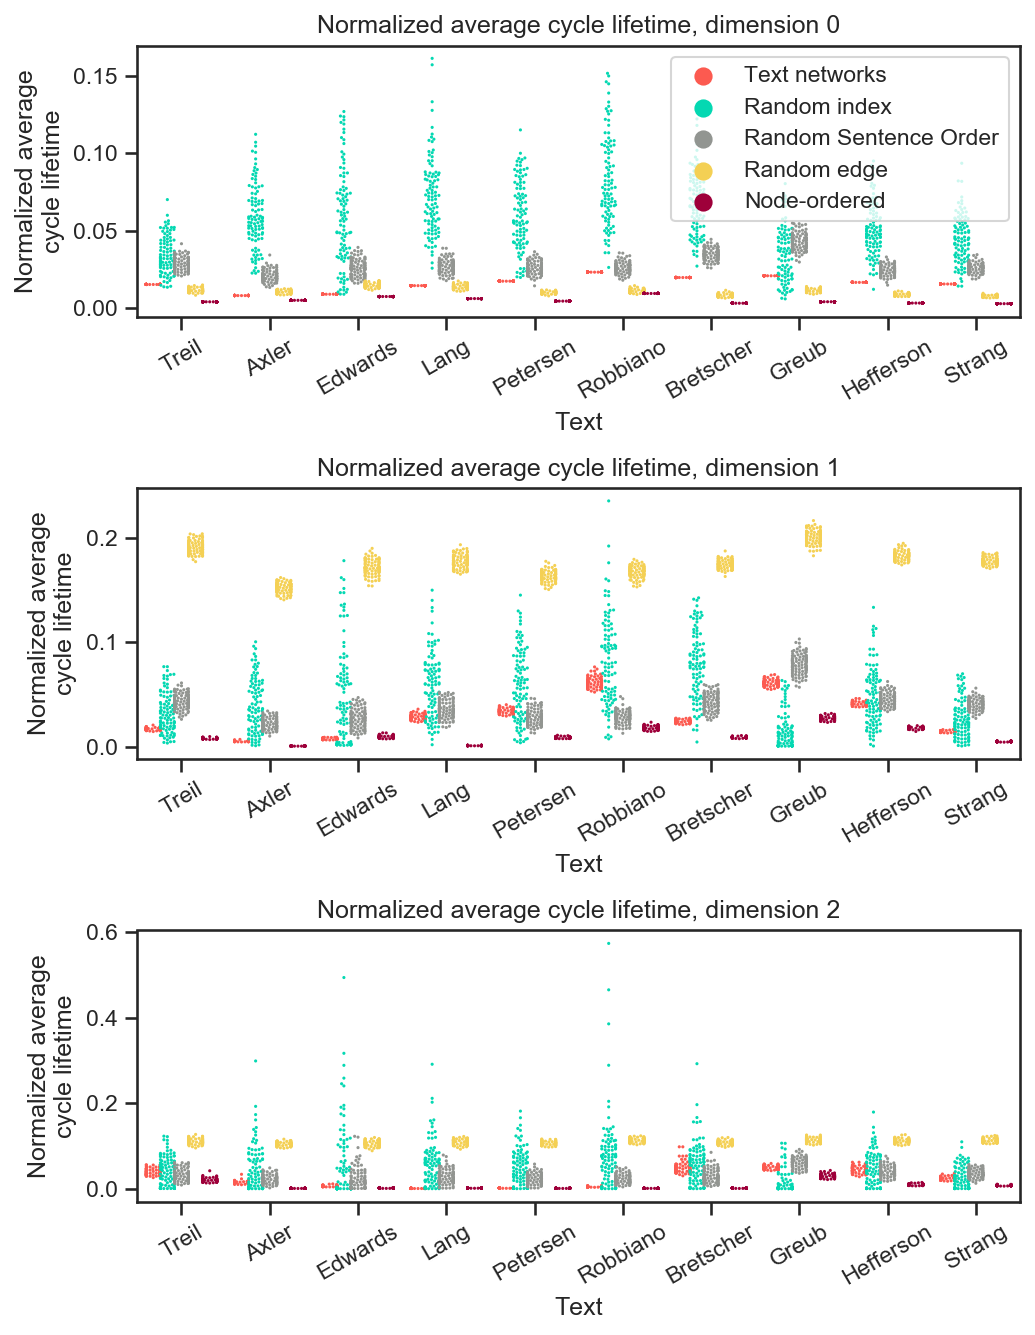

In [9]:
colors = ['xkcd:coral', 'xkcd:aquamarine', 'xkcd:grey', 
          'xkcd:maize', 'xkcd:cranberry']
plt.figure(figsize=(7, 9), dpi=150)
for d in range(3):
    plt.subplot(3, 1, d+1)
    #plt.yscale('log')
    dim_df = big_df.loc[big_df['dimension'] == d]
    sns.swarmplot(x='Text', y='Barcode Density', hue='Model', data=dim_df, 
                  size=1.5, dodge=True, palette=colors, zorder=2)
#     sns.boxplot(x='text', y='density', hue='model', 
#                 data=dim_df, color='black', zorder=1)
    plt.title('Normalized average cycle lifetime, dimension {}'.format(d))
    plt.ylabel('Normalized average\ncycle lifetime')
    plt.xticks(range(10), plottexts, rotation=30)
    plt.legend(loc='upper right')
    if d != 0:
        plt.gca().get_legend().remove()
    
plt.tight_layout()
plt.savefig('figures/barcode_density_supp.png'.format(d), 
            transparent=True, bbox_inches='tight')

plt.show()

In [10]:
sent_coocs = load_sent_coocs()
sent_lens = load_n_sents()

Now, we will investigate potential relationships between normalized average cycle lifetimes and other characteristics of the texts, such as Goodreads rating.

In [11]:
sent_filts = load_sent_filts()

In [12]:
# generating statistics
from bct import core_periphery_dir, community_louvain

true_cms = load_sent_coocs()

true_C, true_qc = [], []
true_M, true_qm = [], []
for true_cm in tqdm_notebook(true_cms):
    C, qc = core_periphery_dir(true_cm)
    true_C.append(C)
    true_qc.append(qc)
    # get the periphery indices only
    P = np.array(1 - C, dtype=bool) 
    M, qm = community_louvain(true_cm[P, :][:, P])
    true_M.append(M)
    true_qm.append(qm)
    
r_ind_C = load_r_ind_C()
r_ind_qc = load_r_ind_qc()
r_ind_M = load_r_ind_M()
r_ind_qm = load_r_ind_qm()

r_sentord_C = load_r_sentord_C()
r_sentord_qc = load_r_sentord_qc()
r_sentord_M = load_r_sentord_M()
r_sentord_qm = load_r_sentord_qm()

cont_config_qc = load_cont_config_qc()
cont_config_qm = load_cont_config_qm()


m_r_ind_qc = np.mean(r_ind_qc, axis=1)
m_r_sentord_qc = np.mean(r_sentord_qc, axis=1)
m_cont_config_qc = np.mean(cont_config_qc, axis=1)

m_r_ind_qm = np.mean(r_ind_qm, axis=1)
m_r_sentord_qm = np.mean(r_sentord_qm, axis=1)
m_cont_config_qm = np.mean(cont_config_qm, axis=1)

true_diff_areas = []
for i in range(10):
    peris, cores = group_node_intro(sent_filts[i], 
                                    true_C[i], 
                                    sent_lens[i])
    true_diff_areas.append(normed_diff_area(cores, peris))
    
r_ind_filts = load_r_ind_filt_mats()
r_ind_diff_areas = []

for i in range(10):
    r_ind_diff_areas.append([])
    for j in range(100):
        peris, cores = np.array(group_node_intro(r_ind_filts[i][j],
                                                       r_ind_C[i][j],
                                                       sent_lens[i]))
        r_ind_diff_areas[i].append(normed_diff_area(cores, peris))
m_r_ind_diff_areas = np.mean(r_ind_diff_areas, axis=1)    
    
r_sentord_filts = load_r_sentord_filt_mats()
r_sentord_diff_areas = []

for i in range(10):
    r_sentord_diff_areas.append([])
    for j in range(100):
        peris, cores = np.array(group_node_intro(r_sentord_filts[i][j],
                                                       r_sentord_C[i][j],
                                                       sent_lens[i]))
        r_sentord_diff_areas[i].append(normed_diff_area(cores, peris))
m_r_sentord_diff_areas = np.mean(r_sentord_diff_areas, axis=1)  
        
true_comm_ks = []
for i in range(10):
    x = group_edge_intro(sent_filts[i], true_C[i], 
                         true_M[i], sent_lens[i])
    x = x[~np.any(np.isnan(x), axis=1)]
    xtest = x
    diff = xtest - np.linspace(0, 1, xtest.shape[1])
    max_magns = diff[np.arange(diff.shape[0]), 
                     np.argmax(np.abs(diff), axis=1)]
    true_comm_ks.append(np.mean(np.abs(max_magns[3:])))

# copied over from the other notebook
r_ind_comm_ks = np.array([0.5118038691731763, 0.5568404881910347, 
                 0.6289870894631411, 0.6449300592053773, 
                 0.5786818885677911, 0.6550009960141654, 
                 0.6102316521931926, 0.5102684444928418, 
                 0.5986742067077634, 0.5926595767133365])
    
r_sentord_comm_ks = np.array([0.27005125660296075, 0.30391976734795895, 
                              0.23625010963811516, 0.30730669448757925, 
                              0.2705330764660125, 0.2537946069544722, 
                              0.2791268298031839, 0.23997582620198188, 
                              0.22427305632599462, 0.20160268919174587])


/Users/nicochristianson/Desktop/Bassett Work/Work/Analysis.py:405: RuntimeWarning: invalid value encountered in true_divide
  return (devs.T / np.max(devs, axis=1)).T


In [13]:
# Goodreads ratings data
sel_texts = np.array([0, 1, 3, 6, 7, 8, 9])
ratings = [3.83, 4.26, 4.23, 3.37, 3.43, 3.96, 4.21]
n_ratings = [6, 673, 31, 71, 7, 25, 891]

ratings_nan = [3.83, 4.26, np.nan, 4.23, np.nan, 
               np.nan, 3.37, 3.43, 3.96, 4.21]
n_ratings_nan = [6, 673, np.nan, 31, np.nan, 
                 np.nan, 71, 7, 25, 891]

In [16]:
a_rat_nan = [np.nan, 4.1, np.nan, 3.2, np.nan, np.nan, 2.9, np.nan, 4.4, 3.6]
a_n_rat_nan = [np.nan, 50, np.nan, 15, np.nan, np.nan, 59, np.nan, 9, 47]

In [14]:
# generate dataframe with all this data
import pandas as pd
plottexts = ['Treil', 'Axler', 'Edwards', 'Lang', 'Petersen', 'Robbiano',
             'Bretscher', 'Greub', 'Hefferson', 'Strang']
labels = load_index_labels()
all_texts = load_text()
num_det = count_occ('determinant', all_texts, text_lens)
num_proof = count_occ('proof', all_texts, text_lens)
num_system = count_occ('system', all_texts, text_lens)
num_comp = count_occ('comput', all_texts, text_lens)
num_calculat = count_occ('calculat', all_texts, text_lens)

coocs = load_sent_coocs()
edge_counts = []
for cooc in coocs:
    np.fill_diagonal(cooc, 0)
    G = nx.from_numpy_array(cooc)
    edge_counts.append(nx.density(G))
    
avg_sent_density = (true_sent_density[:, 2, 0] + true_sent_density[:, 2, 1] + true_sent_density[:, 2, 2])/3
avg_oaat_density = (np.mean(true_oaat_density, axis=1)[:, 2, 0]
                    + np.mean(true_oaat_density, axis=1)[:, 2, 1]
                    + np.mean(true_oaat_density, axis=1)[:, 2, 2])/3

data = list(zip(true_sent_density[:, 2, 0], true_sent_density[:, 2, 1], 
                true_sent_density[:, 2, 2], avg_sent_density,
                np.mean(true_oaat_density, axis=1)[:, 2, 0], np.mean(true_oaat_density, axis=1)[:, 2, 1], 
                np.mean(true_oaat_density, axis=1)[:, 2, 2], avg_oaat_density,
                true_qc, true_qm, true_diff_areas, true_comm_ks,
                num_proof, num_comp,
                ratings_nan, n_ratings_nan, 
                text_lens, [len(l) for l in labels], edge_counts))
cols =  [
         'NACL 0', 'NACL 1', 'NACL 2', 'Avg. NACL',
         'OAAT NACL 0', 'OAAT NACL 1', 'OAAT NACL 2', 'Avg. OAAT NACL',
         'Core-ness', 'Modularity', 'Core - periph. area', 'Intra-comm. K-S',
         '"Proof" freq.', '"Comput-" freq.', 
         'Avg. rating', '# ratings',
         '# sentences', 'Node count', 'Edge density']
corr_df = pd.DataFrame(data, columns=cols)
corr_df

NACL 0    NACL 1    NACL 2  Avg. NACL  OAAT NACL 0  OAAT NACL 1  \
0  0.076989  0.057992  0.112600   0.082527     0.015097     0.017044   
1  0.097713  0.121119  0.195070   0.137967     0.007948     0.005389   
2  0.085118  0.042753  0.019532   0.049135     0.008835     0.007494   
3  0.106267  0.094381  0.000000   0.066883     0.014363     0.028358   
4  0.102189  0.131830  0.001524   0.078514     0.017237     0.034149   
5  0.169309  0.298222  0.021577   0.163036     0.023088     0.061162   
6  0.107406  0.093755  0.116268   0.105810     0.019600     0.024216   
7  0.067836  0.175749  0.119713   0.121100     0.020726     0.061052   
8  0.103089  0.141162  0.144111   0.129454     0.016444     0.041395   
9  0.110394  0.066516  0.085254   0.087388     0.015394     0.014407   

   OAAT NACL 2  Avg. OAAT NACL  Core-ness  Modularity  Core - periph. area  \
0     0.038710        0.023617   1.011434    0.663566             0.133617   
1     0.014438        0.009259   0.970327    0.571172             0.065294   
2     0.006181        0.007504   0.964041    0.516947             0.198165   
3     0.000776        0.014499   0.961720    0.539315             0.087080   
4     0.001196        0.017527   1.108460    0.461316             0.113573   
5     0.004718        0.029656   0.882530    0.478699             0.099772   
6     0.048326        0.030714   1.144580    0.608925             0.064007   
7     0.049684        0.043821   0.979329    0.635572             0.089299   
8     0.044235        0.034025   1.042669    0.609210             0.098994   
9     0.023962        0.017921   1.057003    0.584988             0.130980   

   Intra-comm. K-S  "Proof" freq.  "Comput-" freq.  Avg. rating  # ratings  \
0         0.506245       0.031432         0.023350         3.83        6.0   
1         0.430230       0.085545         0.013744         4.26      673.0   
2         0.441997       0.031462         0.020813          NaN        NaN   
3         0.422877       0.037393         0.009601         4.23       31.0   
4         0.370994       0.035354         0.012539          NaN        NaN   
5         0.437835       0.006114         0.004416          NaN        NaN   
6         0.463308       0.006298         0.011651         3.37       71.0   
7         0.478304       0.018711         0.001169         3.43        7.0   
8         0.381128       0.024360         0.021626         3.96       25.0   
9         0.515205       0.007570         0.024989         4.21      891.0   

   # sentences  Node count  Edge density  
0         6681         278      0.092279  
1         4220         217      0.180449  
2         2066         146      0.204157  
3         3958         179      0.162388  
4         5742         244      0.150779  
5         2944         219      0.169369  
6        12703         384      0.081008  
7         6841         275      0.094333  
8         8046         399      0.082127  
9        10965         453      0.075758

In [94]:
import pingouin as pg
corrs = np.zeros((len(corr_df.columns), len(corr_df.columns)))
for i in range(corrs.shape[0]):
    for j in range(corrs.shape[1]):
        corrs[i, j] = pg.corr(corr_df[corr_df.columns[i]], corr_df[corr_df.columns[j]], method='spearman')['p-val']

In [122]:
from matplotlib.colors import LinearSegmentedColormap

clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

In [132]:
dlist = [(0.1, 0.6, 1.0)]
for i in range(20):
    dlist.append((19-i)/50*np.array((0.1, 0.6, 1.0)) + np.array((0.05, 0.05, 0.05)))
blue_grey = LinearSegmentedColormap.from_list("custom_blue_grey", dlist)

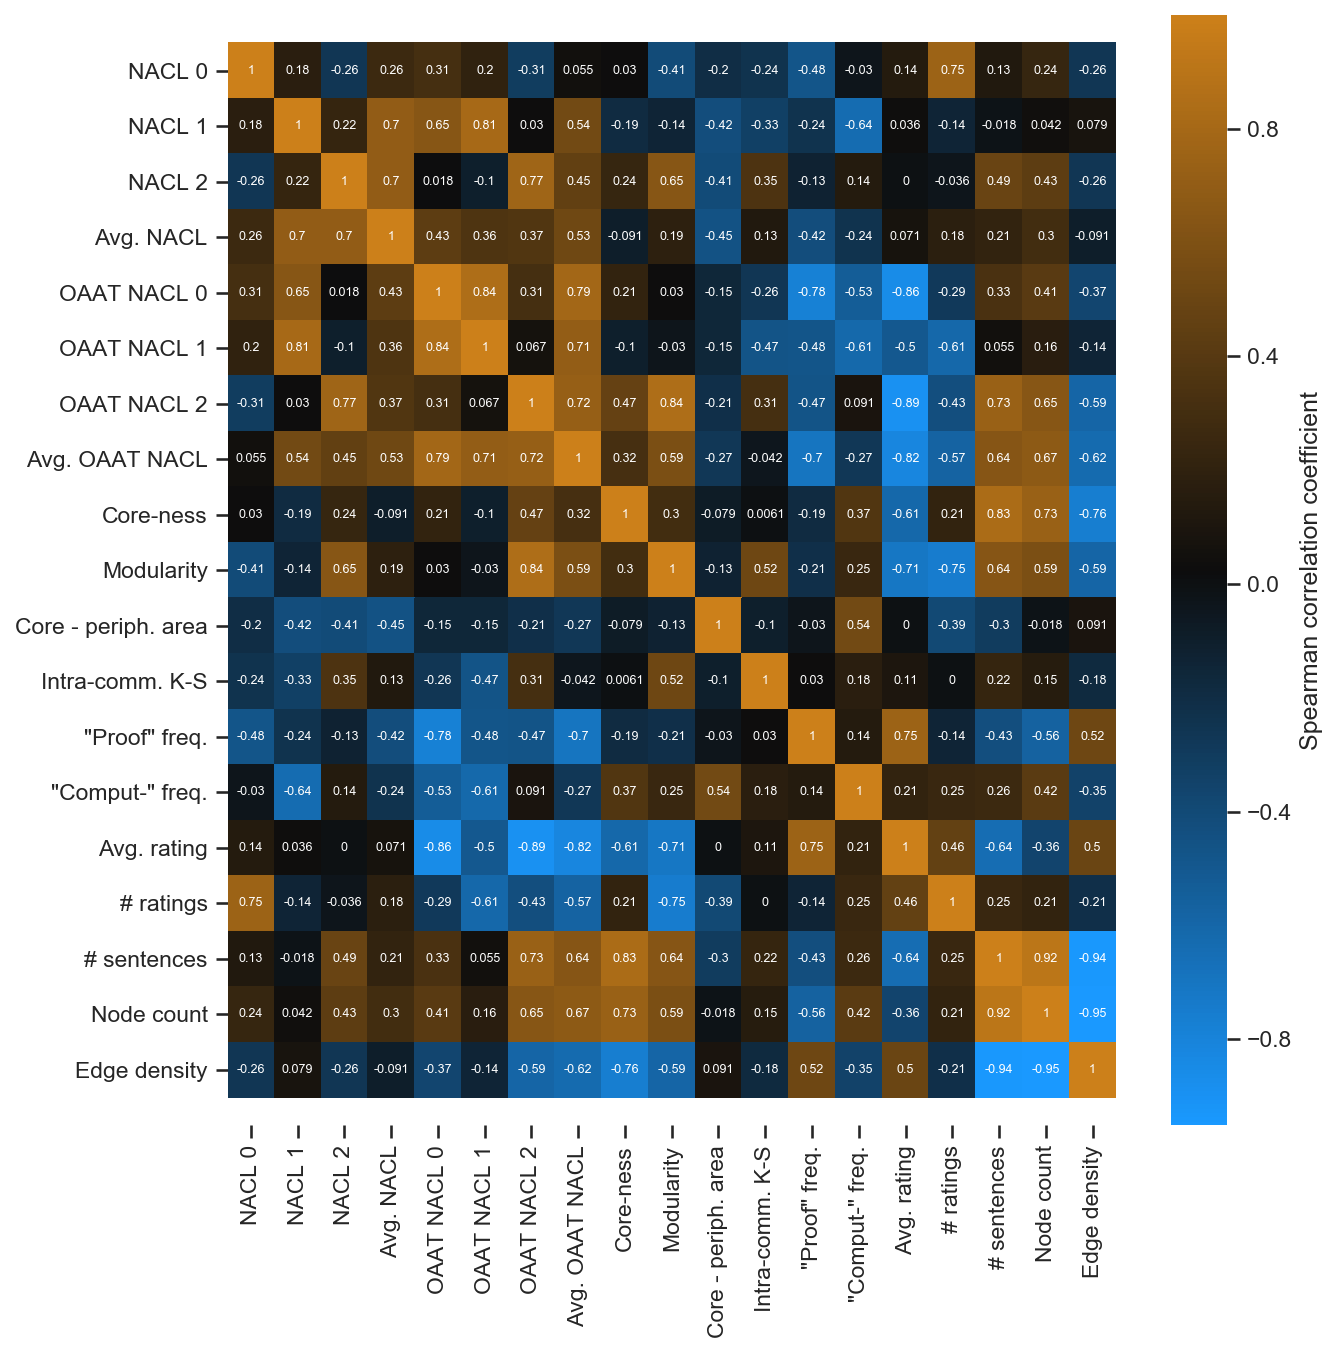

In [146]:
import matplotlib
matplotlib.rcParams.update({'font.size': 6})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 

correlationMatrix = corr_df.corr(method='spearman')

plt.figure(figsize=(9, 9), dpi=150)
sns.heatmap(correlationMatrix, annot=True, cmap=blue_orange_divergent, cbar_kws={'label':'Spearman correlation coefficient'})
plt.gca().set_ylim(len(corr_df.columns)+0.5, -0.5)
# sns.heatmap(correlationMatrix, annot=True, cbar=True, mask=np.abs(correlationMatrix<0.64), cmap='coolwarm', square=True)
plt.tight_layout()
plt.savefig('figures/spearman_corr.png', 
            transparent=True, bbox_inches='tight')
plt.show()

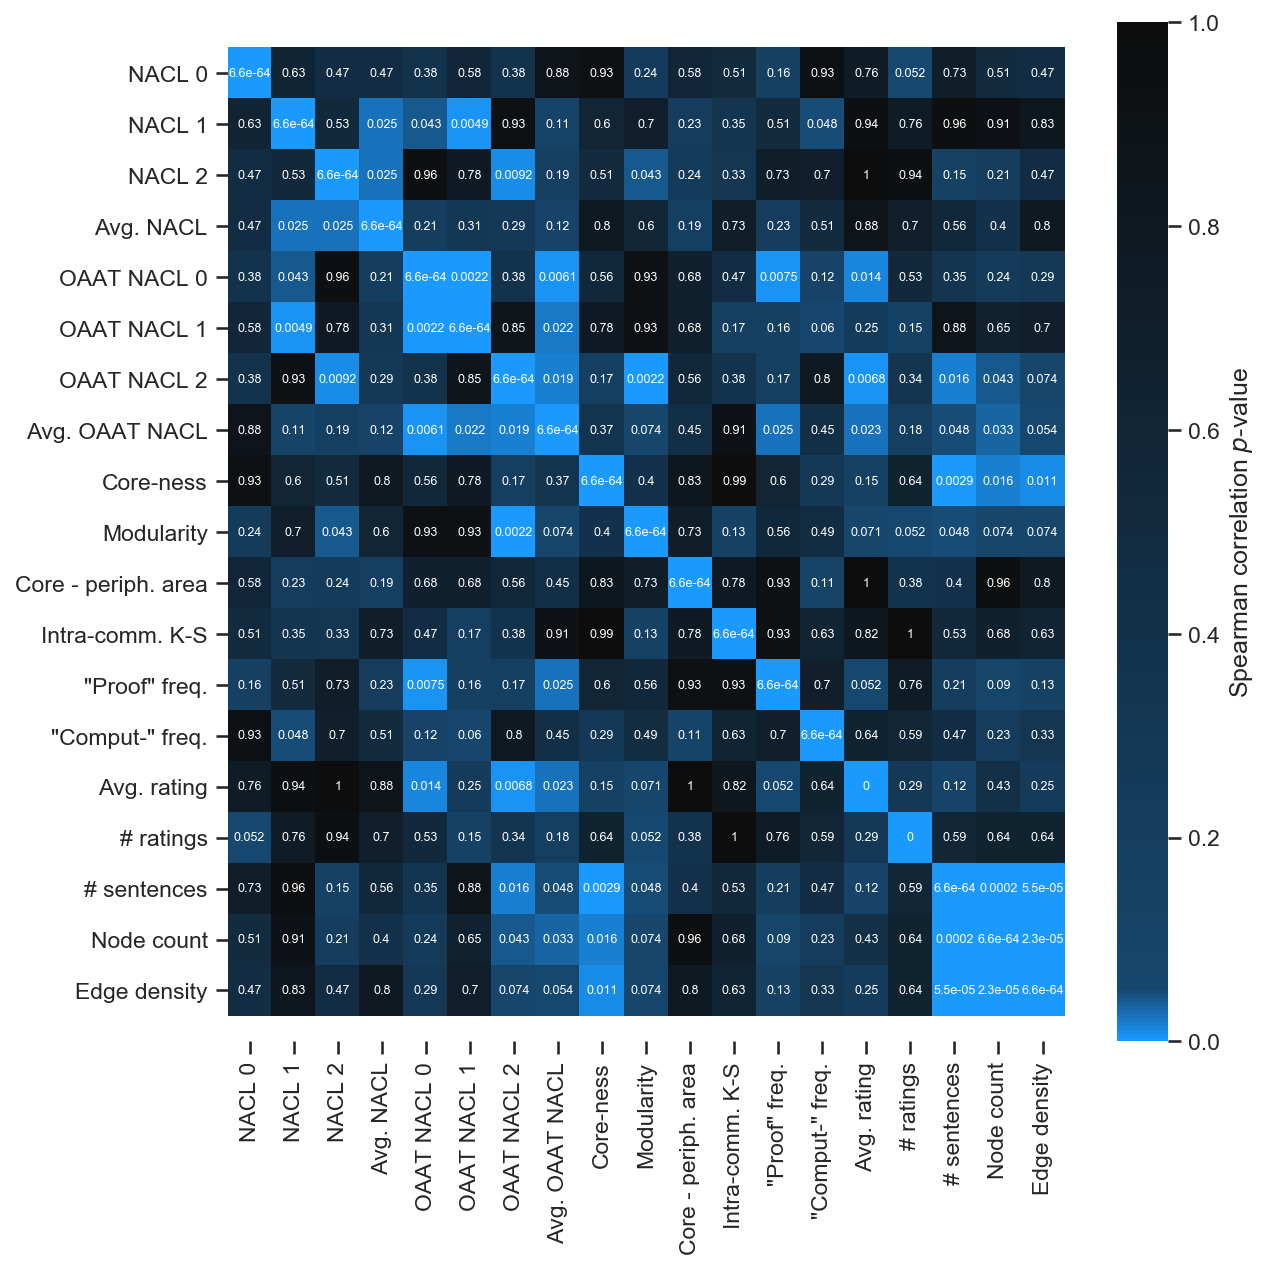

In [145]:
import matplotlib.colors as colors
import copy

plt.figure(figsize=(9, 9), dpi=150)
sns.heatmap(corrs, annot=True, cmap=blue_grey, cbar_kws={'label':'Spearman correlation $p$-value'},
            xticklabels=list(corr_df.columns), yticklabels=list(corr_df.columns))
plt.gca().set_ylim(len(corr_df.columns)+0.5, -0.5)
plt.savefig('figures/spearman_p.png', 
            transparent=True, bbox_inches='tight')
plt.show()

In [143]:
list(corr_df.columns)

['NACL 0',
 'NACL 1',
 'NACL 2',
 'Avg. NACL',
 'OAAT NACL 0',
 'OAAT NACL 1',
 'OAAT NACL 2',
 'Avg. OAAT NACL',
 'Core-ness',
 'Modularity',
 'Core - periph. area',
 'Intra-comm. K-S',
 '"Proof" freq.',
 '"Comput-" freq.',
 'Avg. rating',
 '# ratings',
 '# sentences',
 'Node count',
 'Edge density']

In [63]:
for col in corr_df.columns[1:]:
    if col == 'Avg. ratings' or col == 'nratings':
        tmp_df = corr_df.dropna()
    else:
        tmp_df = corr_df
    W, p = st.shapiro(tmp_df[col])
    if p < 0.05:
        print(col, p)

ndens0 0.03940686583518982
nproof 0.024307824671268463
ncalculat 1.7564912923262455e-05
nratings 0.0027534610126167536


In [148]:
pg.corr(corr_df['"Proof" freq.'], corr_df['Avg. OAAT NACL'], method='spearman')

n      r           CI95%     r2  adj_r2     p-val  power
spearman  10 -0.697  [-0.92, -0.12]  0.486   0.339  0.025097   0.66

In [90]:
for col in corr_df.columns[:8]:
    sp_corr = pg.corr(corr_df[col], corr_df['Avg. rating'], method='spearman')
    pea_corr = pg.corr(corr_df[col], corr_df['Avg. rating'], method='pearson')
    print(col)
    print('spearman', sp_corr['r'][0], sp_corr['p-val'][0])
    print('pearson', pea_corr['r'][0], pea_corr['p-val'][0])
    print()

NACL 0
spearman 0.143 0.7599453002180929
pearson 0.466 0.2914736657792087

NACL 1
spearman 0.036 0.9394082054712856
pearson -0.334 0.46361004903174813

NACL 2
spearman 0.0 1.0
pearson -0.145 0.7572229760965831

Avg. NACL
spearman 0.071 0.8790481931481541
pearson -0.187 0.6886656504573547

OAAT NACL 0
spearman -0.857 0.01369732661532562
pearson -0.821 0.023657461245799274

OAAT NACL 1
spearman -0.5 0.25316999510032273
pearson -0.575 0.1773143924264162

OAAT NACL 2
spearman -0.893 0.006807187408935392
pearson -0.846 0.016300064178063556

Avg. OAAT NACL
spearman -0.821 0.023448808345691505
pearson -0.828 0.021325122149299974



In [87]:
st.spearmanr((-corr_df.dropna()['oaat ndens0'] + corr_df.dropna()['oaat ndens1'] + corr_df.dropna()['oaat ndens2'])/3, corr_df.dropna()['ratings'])

SpearmanrResult(correlation=-0.8214285714285715, pvalue=0.023448808345691505)

Goodreads ratings vs. the NACLs, both regular and OAAT

 0 pearson          n      r         CI95%     r2  adj_r2     p-val   BF10  power
pearson  7  0.466  [-0.44, 0.9]  0.218  -0.174  0.291474  0.743  0.191
 0 spearman           n      r          CI95%    r2  adj_r2     p-val  power
spearman  7  0.143  [-0.68, 0.81]  0.02  -0.469  0.759945   0.06
 1 pearson          n      r          CI95%     r2  adj_r2    p-val   BF10  power
pearson  7 -0.334  [-0.87, 0.56]  0.112  -0.332  0.46361  0.579  0.115
 1 spearman           n      r          CI95%     r2  adj_r2     p-val  power
spearman  7  0.036  [-0.74, 0.77]  0.001  -0.498  0.939408   0.05
 2 pearson          n      r          CI95%     r2  adj_r2     p-val   BF10  power
pearson  7 -0.145  [-0.81, 0.68]  0.021  -0.469  0.757223  0.477  0.061
 2 spearman           n    r          CI95%   r2  adj_r2  p-val  power
spearman  7  0.0  [-0.75, 0.75]  0.0    -0.5    1.0  0.049
 3 pearson          n      r          CI95%     r2  adj_r2     p-val   BF10  power
pearson  7 -0.187  [-0.82, 0.66]  0.035 

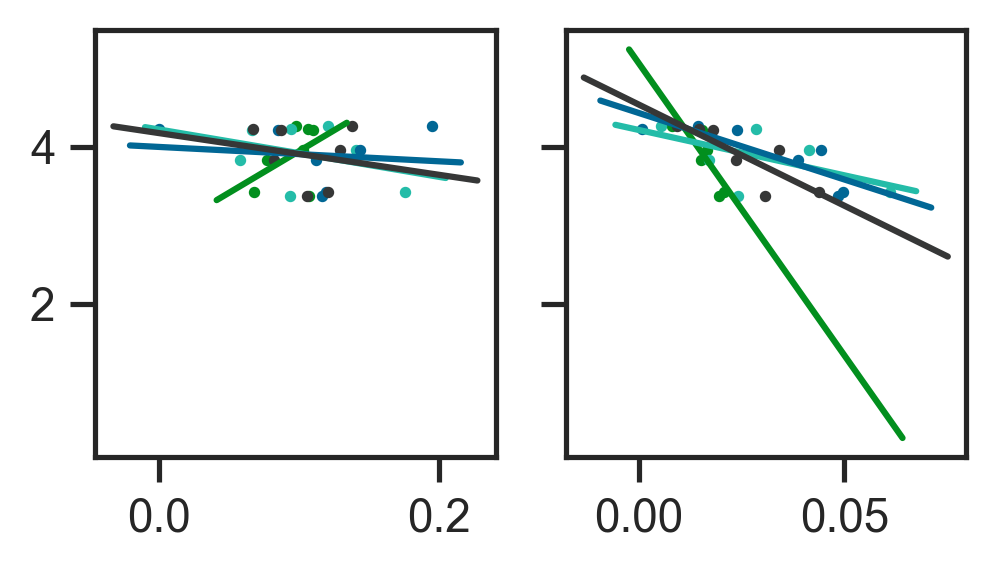

In [19]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

tmp_df = corr_df.dropna()

colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue', 'xkcd:dark grey']
dens_type = ['', 'OAAT ']
metric_name = ['Dimension 0', 'Dimension 1', 'Dimension 2', 'Average']
fig, ax = plt.subplots(1, 2, figsize=(3.42, 2), dpi=300, sharey=True)
for i in range(2):
    stuff = []
    for d in range(4):
        if d < 3:
            dens = '{}NACL {}'.format(dens_type[i], d)
        else:
            dens = 'Avg. {}NACL'.format(dens_type[i])
        
        m,b,r,p,s = st.linregress(tmp_df[dens], tmp_df['Avg. rating'])
        ax[i].scatter(tmp_df[dens], tmp_df['Avg. rating'], 
                    color=colors[d], s=3,
                    label=metric_name[d])
        print(dens_type[i], d, 'pearson', pg.corr(tmp_df[dens], tmp_df['Avg. rating'], method='pearson'))
        print(dens_type[i], d, 'spearman', pg.corr(tmp_df[dens], tmp_df['Avg. rating'], method='spearman'))
        stuff.append((m,b,r,p,s))
    for d in range(4):
        m,b,r,p,s = stuff[d]
        x = list(ax[i].get_xlim())
        y = ax[i].get_ylim()
        if m > 0:
            x[0] = np.max([x[0], (y[0]-b)/m])
            x[1] = np.min([x[1], (y[1]-b)/m])
        else:
            x[0] = np.min([x[0], (y[0]-b)/m])
            x[1] = np.max([x[1], (y[1]-b)/m])
        x = np.linspace(x[0], x[1], 2)
        ax[i].plot(x, m*x+b, color=colors[d], zorder=1)
plt.tight_layout()
plt.savefig('figures/all_correlation.pdf'.format(i), 
            transparent=True, bbox_inches='tight')
plt.show()